In [1]:
import torch
import torchvision.datasets as datasets  # Standard datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle


from PIL import Image
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

DATA_DIR = './petfaces'

image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [3]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

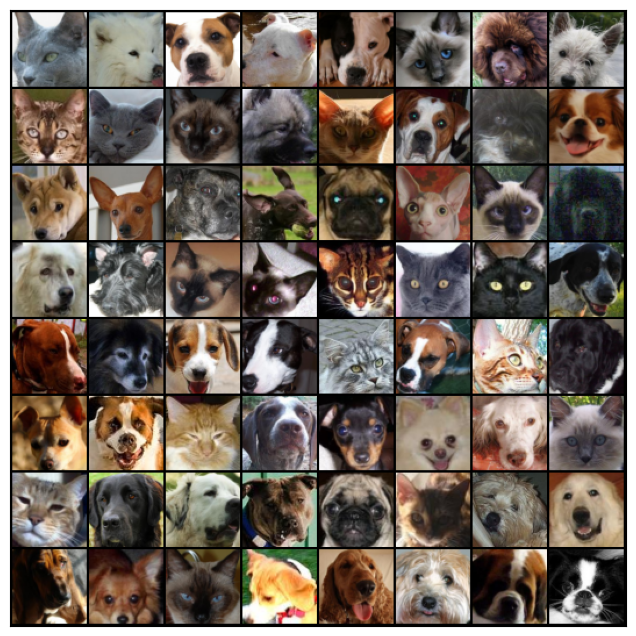

In [4]:
show_batch(train_dl)

In [5]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [6]:
device = get_default_device()
device

device(type='cuda')

In [7]:
train_dl = DeviceDataLoader(train_dl, device)

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [9]:
discriminator = to_device(discriminator, device)

In [10]:
latent_size = 128

In [11]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


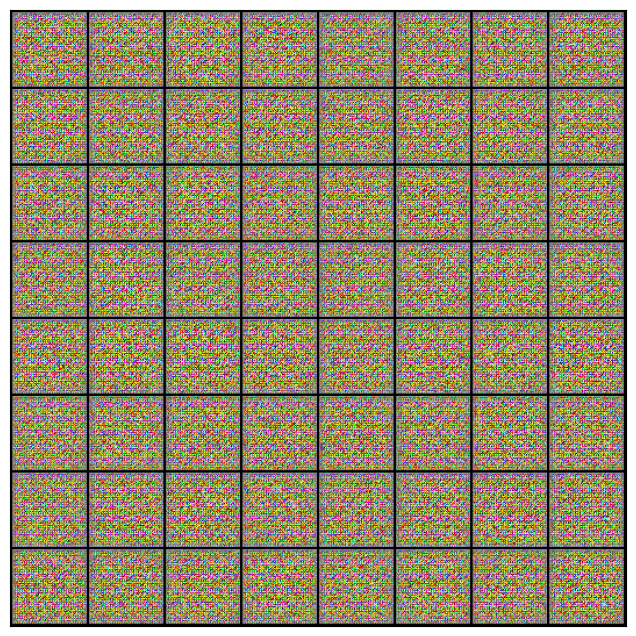

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [13]:
generator = to_device(generator, device)

In [14]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [15]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [16]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


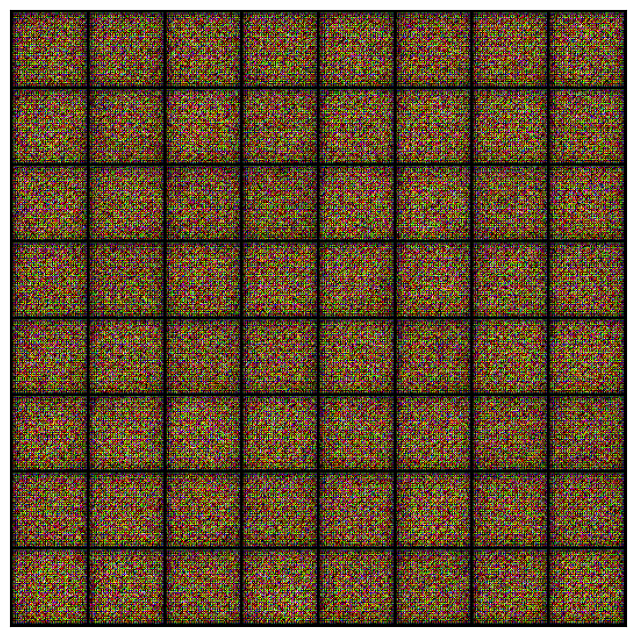

In [18]:
save_samples(0, fixed_latent)

In [19]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [20]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [21]:
lr = 0.0002
epochs = 700

In [22]:
history = fit(epochs, lr)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1/700], loss_g: 8.7282, loss_d: 0.1297, real_score: 0.8833, fake_score: 0.0007
Saving generated-images-0001.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2/700], loss_g: 8.8470, loss_d: 0.6597, real_score: 0.9668, fake_score: 0.4555
Saving generated-images-0002.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3/700], loss_g: 5.4697, loss_d: 0.1956, real_score: 0.9671, fake_score: 0.1475
Saving generated-images-0003.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4/700], loss_g: 3.3100, loss_d: 0.3547, real_score: 0.8229, fake_score: 0.1299
Saving generated-images-0004.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5/700], loss_g: 0.6163, loss_d: 0.8951, real_score: 0.4928, fake_score: 0.0393
Saving generated-images-0005.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6/700], loss_g: 3.4442, loss_d: 0.3030, real_score: 0.8644, fake_score: 0.1351
Saving generated-images-0006.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7/700], loss_g: 3.6863, loss_d: 0.5285, real_score: 0.7066, fake_score: 0.0597
Saving generated-images-0007.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8/700], loss_g: 5.7227, loss_d: 0.3769, real_score: 0.7298, fake_score: 0.0075
Saving generated-images-0008.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9/700], loss_g: 6.3565, loss_d: 0.0697, real_score: 0.9577, fake_score: 0.0211
Saving generated-images-0009.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10/700], loss_g: 7.3115, loss_d: 0.0722, real_score: 0.9687, fake_score: 0.0383
Saving generated-images-0010.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [11/700], loss_g: 5.8923, loss_d: 0.0651, real_score: 0.9472, fake_score: 0.0085
Saving generated-images-0011.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [12/700], loss_g: 6.6743, loss_d: 0.0144, real_score: 0.9973, fake_score: 0.0116
Saving generated-images-0012.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [13/700], loss_g: 6.9373, loss_d: 0.0217, real_score: 0.9919, fake_score: 0.0134
Saving generated-images-0013.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [14/700], loss_g: 5.9910, loss_d: 0.0463, real_score: 0.9608, fake_score: 0.0053
Saving generated-images-0014.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [15/700], loss_g: 16.9041, loss_d: 12.8574, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0015.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [16/700], loss_g: 7.9658, loss_d: 0.4073, real_score: 0.8101, fake_score: 0.0011
Saving generated-images-0016.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [17/700], loss_g: 4.5398, loss_d: 0.1954, real_score: 0.8710, fake_score: 0.0263
Saving generated-images-0017.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [18/700], loss_g: 7.9991, loss_d: 0.1391, real_score: 0.9963, fake_score: 0.1238
Saving generated-images-0018.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [19/700], loss_g: 11.3669, loss_d: 2.3077, real_score: 0.9973, fake_score: 0.8343
Saving generated-images-0019.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [20/700], loss_g: 4.1349, loss_d: 0.3665, real_score: 0.8386, fake_score: 0.1520
Saving generated-images-0020.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [21/700], loss_g: 4.1965, loss_d: 0.0840, real_score: 0.9412, fake_score: 0.0199
Saving generated-images-0021.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [22/700], loss_g: 5.3389, loss_d: 0.3129, real_score: 0.7622, fake_score: 0.0064
Saving generated-images-0022.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [23/700], loss_g: 7.1649, loss_d: 0.5038, real_score: 0.8387, fake_score: 0.2445
Saving generated-images-0023.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [24/700], loss_g: 5.7878, loss_d: 0.3514, real_score: 0.9063, fake_score: 0.1682
Saving generated-images-0024.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [25/700], loss_g: 3.8472, loss_d: 0.2991, real_score: 0.9232, fake_score: 0.1883
Saving generated-images-0025.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [26/700], loss_g: 3.5248, loss_d: 0.2465, real_score: 0.8601, fake_score: 0.0802
Saving generated-images-0026.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [27/700], loss_g: 6.1223, loss_d: 0.2679, real_score: 0.8042, fake_score: 0.0039
Saving generated-images-0027.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [28/700], loss_g: 2.5962, loss_d: 0.3556, real_score: 0.8101, fake_score: 0.1025
Saving generated-images-0028.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [29/700], loss_g: 4.7976, loss_d: 0.6821, real_score: 0.8675, fake_score: 0.3859
Saving generated-images-0029.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [30/700], loss_g: 4.9534, loss_d: 0.1637, real_score: 0.9410, fake_score: 0.0737
Saving generated-images-0030.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [31/700], loss_g: 4.1411, loss_d: 0.4457, real_score: 0.8974, fake_score: 0.2326
Saving generated-images-0031.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [32/700], loss_g: 4.2634, loss_d: 0.6707, real_score: 0.8451, fake_score: 0.3222
Saving generated-images-0032.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [33/700], loss_g: 7.9002, loss_d: 0.9235, real_score: 0.9738, fake_score: 0.5255
Saving generated-images-0033.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [34/700], loss_g: 1.1051, loss_d: 1.5666, real_score: 0.2816, fake_score: 0.0251
Saving generated-images-0034.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [35/700], loss_g: 3.8307, loss_d: 0.1785, real_score: 0.8474, fake_score: 0.0074
Saving generated-images-0035.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [36/700], loss_g: 4.5208, loss_d: 0.4574, real_score: 0.8793, fake_score: 0.2532
Saving generated-images-0036.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [37/700], loss_g: 3.1018, loss_d: 0.4498, real_score: 0.8059, fake_score: 0.1704
Saving generated-images-0037.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [38/700], loss_g: 0.9548, loss_d: 0.8661, real_score: 0.5211, fake_score: 0.1262
Saving generated-images-0038.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [39/700], loss_g: 4.4344, loss_d: 0.3093, real_score: 0.9762, fake_score: 0.2221
Saving generated-images-0039.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [40/700], loss_g: 1.9593, loss_d: 0.5271, real_score: 0.7442, fake_score: 0.1739
Saving generated-images-0040.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [41/700], loss_g: 2.1562, loss_d: 0.4996, real_score: 0.6599, fake_score: 0.0505
Saving generated-images-0041.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [42/700], loss_g: 1.4018, loss_d: 0.9960, real_score: 0.5446, fake_score: 0.0484
Saving generated-images-0042.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [43/700], loss_g: 3.3669, loss_d: 0.2454, real_score: 0.8804, fake_score: 0.0855
Saving generated-images-0043.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [44/700], loss_g: 2.5613, loss_d: 0.9049, real_score: 0.4989, fake_score: 0.0136
Saving generated-images-0044.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [45/700], loss_g: 5.9377, loss_d: 0.0749, real_score: 0.9495, fake_score: 0.0220
Saving generated-images-0045.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [46/700], loss_g: 3.7931, loss_d: 0.3128, real_score: 0.9287, fake_score: 0.1923
Saving generated-images-0046.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [47/700], loss_g: 1.9054, loss_d: 0.3344, real_score: 0.8093, fake_score: 0.1013
Saving generated-images-0047.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [48/700], loss_g: 1.9521, loss_d: 0.6259, real_score: 0.6758, fake_score: 0.1759
Saving generated-images-0048.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [49/700], loss_g: 3.5592, loss_d: 0.7785, real_score: 0.5396, fake_score: 0.0105
Saving generated-images-0049.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [50/700], loss_g: 2.9375, loss_d: 0.7368, real_score: 0.6162, fake_score: 0.0708
Saving generated-images-0050.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [51/700], loss_g: 4.4882, loss_d: 0.1737, real_score: 0.9718, fake_score: 0.1264
Saving generated-images-0051.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [52/700], loss_g: 3.5688, loss_d: 0.3339, real_score: 0.9057, fake_score: 0.1908
Saving generated-images-0052.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [53/700], loss_g: 2.7859, loss_d: 0.6470, real_score: 0.7260, fake_score: 0.2304
Saving generated-images-0053.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [54/700], loss_g: 7.8127, loss_d: 0.7744, real_score: 0.9403, fake_score: 0.4656
Saving generated-images-0054.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [55/700], loss_g: 1.9047, loss_d: 0.8195, real_score: 0.5660, fake_score: 0.1241
Saving generated-images-0055.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [56/700], loss_g: 2.2130, loss_d: 1.2754, real_score: 0.3739, fake_score: 0.0097
Saving generated-images-0056.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [57/700], loss_g: 4.1573, loss_d: 0.4283, real_score: 0.8214, fake_score: 0.1847
Saving generated-images-0057.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [58/700], loss_g: 4.4949, loss_d: 0.5831, real_score: 0.9117, fake_score: 0.3470
Saving generated-images-0058.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [59/700], loss_g: 3.7165, loss_d: 0.5153, real_score: 0.8567, fake_score: 0.2693
Saving generated-images-0059.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [60/700], loss_g: 4.6807, loss_d: 0.4873, real_score: 0.9468, fake_score: 0.3192
Saving generated-images-0060.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [61/700], loss_g: 5.5562, loss_d: 0.1269, real_score: 0.9373, fake_score: 0.0571
Saving generated-images-0061.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [62/700], loss_g: 2.4648, loss_d: 0.5351, real_score: 0.7547, fake_score: 0.1638
Saving generated-images-0062.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [63/700], loss_g: 4.7829, loss_d: 0.5743, real_score: 0.9086, fake_score: 0.3446
Saving generated-images-0063.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [64/700], loss_g: 2.9721, loss_d: 1.3341, real_score: 0.3087, fake_score: 0.0006
Saving generated-images-0064.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [65/700], loss_g: 2.7324, loss_d: 0.6639, real_score: 0.6837, fake_score: 0.2158
Saving generated-images-0065.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [66/700], loss_g: 2.6781, loss_d: 0.9717, real_score: 0.4333, fake_score: 0.0172
Saving generated-images-0066.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [67/700], loss_g: 1.8777, loss_d: 0.6110, real_score: 0.6466, fake_score: 0.0860
Saving generated-images-0067.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [68/700], loss_g: 3.4982, loss_d: 0.5701, real_score: 0.7645, fake_score: 0.2279
Saving generated-images-0068.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [69/700], loss_g: 1.0641, loss_d: 1.7471, real_score: 0.2493, fake_score: 0.0190
Saving generated-images-0069.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [70/700], loss_g: 4.8852, loss_d: 0.2981, real_score: 0.8465, fake_score: 0.0642
Saving generated-images-0070.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [71/700], loss_g: 4.3885, loss_d: 0.6485, real_score: 0.8334, fake_score: 0.3238
Saving generated-images-0071.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [72/700], loss_g: 8.9171, loss_d: 1.0056, real_score: 0.9712, fake_score: 0.5556
Saving generated-images-0072.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [73/700], loss_g: 5.0038, loss_d: 0.9153, real_score: 0.9912, fake_score: 0.5156
Saving generated-images-0073.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [74/700], loss_g: 3.1824, loss_d: 0.3815, real_score: 0.9410, fake_score: 0.2526
Saving generated-images-0074.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [75/700], loss_g: 5.5651, loss_d: 0.8130, real_score: 0.9734, fake_score: 0.4706
Saving generated-images-0075.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [76/700], loss_g: 1.8838, loss_d: 0.9063, real_score: 0.4762, fake_score: 0.0386
Saving generated-images-0076.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [77/700], loss_g: 1.8742, loss_d: 0.3510, real_score: 0.7937, fake_score: 0.0992
Saving generated-images-0077.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [78/700], loss_g: 3.4943, loss_d: 0.2386, real_score: 0.9226, fake_score: 0.1355
Saving generated-images-0078.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [79/700], loss_g: 3.7043, loss_d: 0.8220, real_score: 0.5294, fake_score: 0.0066
Saving generated-images-0079.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [80/700], loss_g: 2.1853, loss_d: 0.6599, real_score: 0.7183, fake_score: 0.1525
Saving generated-images-0080.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [81/700], loss_g: 3.3705, loss_d: 0.3012, real_score: 0.9404, fake_score: 0.1946
Saving generated-images-0081.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [82/700], loss_g: 1.2818, loss_d: 0.5959, real_score: 0.6086, fake_score: 0.0284
Saving generated-images-0082.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [83/700], loss_g: 0.9958, loss_d: 0.8016, real_score: 0.5874, fake_score: 0.1439
Saving generated-images-0083.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [84/700], loss_g: 2.5450, loss_d: 0.4582, real_score: 0.7142, fake_score: 0.0902
Saving generated-images-0084.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [85/700], loss_g: 4.0461, loss_d: 0.1791, real_score: 0.8852, fake_score: 0.0483
Saving generated-images-0085.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [86/700], loss_g: 2.8152, loss_d: 0.6302, real_score: 0.6130, fake_score: 0.0896
Saving generated-images-0086.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [87/700], loss_g: 4.1806, loss_d: 0.1609, real_score: 0.9540, fake_score: 0.1008
Saving generated-images-0087.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [88/700], loss_g: 5.5337, loss_d: 0.3700, real_score: 0.9317, fake_score: 0.2314
Saving generated-images-0088.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [89/700], loss_g: 1.6746, loss_d: 1.3937, real_score: 0.3288, fake_score: 0.0084
Saving generated-images-0089.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [90/700], loss_g: 3.4091, loss_d: 0.1935, real_score: 0.9574, fake_score: 0.1299
Saving generated-images-0090.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [91/700], loss_g: 3.3469, loss_d: 0.2228, real_score: 0.8677, fake_score: 0.0628
Saving generated-images-0091.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [92/700], loss_g: 7.2999, loss_d: 0.3584, real_score: 0.9393, fake_score: 0.2278
Saving generated-images-0092.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [93/700], loss_g: 1.8700, loss_d: 0.7451, real_score: 0.6342, fake_score: 0.1194
Saving generated-images-0093.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [94/700], loss_g: 2.3570, loss_d: 0.8281, real_score: 0.6794, fake_score: 0.2917
Saving generated-images-0094.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [95/700], loss_g: 3.6451, loss_d: 0.2240, real_score: 0.8937, fake_score: 0.0942
Saving generated-images-0095.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [96/700], loss_g: 3.3464, loss_d: 0.3090, real_score: 0.7790, fake_score: 0.0315
Saving generated-images-0096.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [97/700], loss_g: 7.3349, loss_d: 0.3652, real_score: 0.9783, fake_score: 0.2510
Saving generated-images-0097.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [98/700], loss_g: 4.4571, loss_d: 0.3344, real_score: 0.9329, fake_score: 0.2053
Saving generated-images-0098.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [99/700], loss_g: 3.7827, loss_d: 0.2267, real_score: 0.9867, fake_score: 0.1748
Saving generated-images-0099.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [100/700], loss_g: 8.3171, loss_d: 0.9961, real_score: 0.9694, fake_score: 0.5578
Saving generated-images-0100.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [101/700], loss_g: 4.8742, loss_d: 0.0728, real_score: 0.9794, fake_score: 0.0488
Saving generated-images-0101.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [102/700], loss_g: 8.1362, loss_d: 0.5985, real_score: 0.8950, fake_score: 0.3332
Saving generated-images-0102.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [103/700], loss_g: 5.3262, loss_d: 0.7425, real_score: 0.9467, fake_score: 0.4218
Saving generated-images-0103.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [104/700], loss_g: 1.5753, loss_d: 0.5578, real_score: 0.6383, fake_score: 0.0688
Saving generated-images-0104.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [105/700], loss_g: 4.0758, loss_d: 0.3296, real_score: 0.8624, fake_score: 0.1422
Saving generated-images-0105.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [106/700], loss_g: 6.7380, loss_d: 0.4987, real_score: 0.8875, fake_score: 0.2735
Saving generated-images-0106.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [107/700], loss_g: 4.0128, loss_d: 0.1895, real_score: 0.9028, fake_score: 0.0750
Saving generated-images-0107.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [108/700], loss_g: 6.3937, loss_d: 0.7086, real_score: 0.9592, fake_score: 0.3923
Saving generated-images-0108.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [109/700], loss_g: 4.1749, loss_d: 0.3705, real_score: 0.8600, fake_score: 0.1745
Saving generated-images-0109.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [110/700], loss_g: 0.5628, loss_d: 0.8530, real_score: 0.5016, fake_score: 0.0437
Saving generated-images-0110.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [111/700], loss_g: 1.6278, loss_d: 0.8776, real_score: 0.5982, fake_score: 0.2232
Saving generated-images-0111.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [112/700], loss_g: 3.9250, loss_d: 0.2625, real_score: 0.8953, fake_score: 0.1293
Saving generated-images-0112.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [113/700], loss_g: 4.9366, loss_d: 0.0979, real_score: 0.9419, fake_score: 0.0342
Saving generated-images-0113.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [114/700], loss_g: 4.4835, loss_d: 0.9237, real_score: 0.4764, fake_score: 0.0017
Saving generated-images-0114.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [115/700], loss_g: 4.8040, loss_d: 0.1731, real_score: 0.8891, fake_score: 0.0453
Saving generated-images-0115.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [116/700], loss_g: 4.8749, loss_d: 0.3472, real_score: 0.9074, fake_score: 0.2007
Saving generated-images-0116.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [117/700], loss_g: 1.4722, loss_d: 0.3325, real_score: 0.7706, fake_score: 0.0445
Saving generated-images-0117.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [118/700], loss_g: 4.7078, loss_d: 0.1737, real_score: 0.9322, fake_score: 0.0831
Saving generated-images-0118.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [119/700], loss_g: 5.0547, loss_d: 0.0892, real_score: 0.9717, fake_score: 0.0511
Saving generated-images-0119.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [120/700], loss_g: 6.0492, loss_d: 0.4156, real_score: 0.8873, fake_score: 0.2254
Saving generated-images-0120.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [121/700], loss_g: 3.9443, loss_d: 0.4580, real_score: 0.7917, fake_score: 0.1437
Saving generated-images-0121.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [122/700], loss_g: 4.5518, loss_d: 0.1457, real_score: 0.9131, fake_score: 0.0424
Saving generated-images-0122.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [123/700], loss_g: 3.2545, loss_d: 0.3122, real_score: 0.8584, fake_score: 0.1340
Saving generated-images-0123.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [124/700], loss_g: 1.9500, loss_d: 0.4292, real_score: 0.7748, fake_score: 0.1339
Saving generated-images-0124.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [125/700], loss_g: 1.9312, loss_d: 0.5710, real_score: 0.6736, fake_score: 0.1193
Saving generated-images-0125.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [126/700], loss_g: 5.8598, loss_d: 0.4712, real_score: 0.9584, fake_score: 0.3106
Saving generated-images-0126.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [127/700], loss_g: 4.3108, loss_d: 0.1758, real_score: 0.9249, fake_score: 0.0819
Saving generated-images-0127.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [128/700], loss_g: 7.0266, loss_d: 0.6488, real_score: 0.9529, fake_score: 0.3970
Saving generated-images-0128.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [129/700], loss_g: 2.1561, loss_d: 0.2664, real_score: 0.8031, fake_score: 0.0275
Saving generated-images-0129.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [130/700], loss_g: 4.8855, loss_d: 0.0887, real_score: 0.9898, fake_score: 0.0712
Saving generated-images-0130.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [131/700], loss_g: 3.9960, loss_d: 0.2026, real_score: 0.8847, fake_score: 0.0630
Saving generated-images-0131.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [132/700], loss_g: 5.3520, loss_d: 0.3315, real_score: 0.9966, fake_score: 0.2528
Saving generated-images-0132.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [133/700], loss_g: 5.4995, loss_d: 0.1997, real_score: 0.8316, fake_score: 0.0057
Saving generated-images-0133.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [134/700], loss_g: 5.2071, loss_d: 0.7238, real_score: 0.8989, fake_score: 0.3390
Saving generated-images-0134.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [135/700], loss_g: 4.6020, loss_d: 0.4792, real_score: 0.8197, fake_score: 0.1852
Saving generated-images-0135.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [136/700], loss_g: 3.8337, loss_d: 0.1430, real_score: 0.9376, fake_score: 0.0685
Saving generated-images-0136.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [137/700], loss_g: 5.3078, loss_d: 0.1874, real_score: 0.9627, fake_score: 0.1267
Saving generated-images-0137.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [138/700], loss_g: 5.3598, loss_d: 0.2072, real_score: 0.8343, fake_score: 0.0155
Saving generated-images-0138.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [139/700], loss_g: 1.4607, loss_d: 0.5577, real_score: 0.7891, fake_score: 0.2073
Saving generated-images-0139.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [140/700], loss_g: 3.9285, loss_d: 0.2542, real_score: 0.8036, fake_score: 0.0119
Saving generated-images-0140.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [141/700], loss_g: 4.4222, loss_d: 0.6978, real_score: 0.7922, fake_score: 0.2815
Saving generated-images-0141.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [142/700], loss_g: 2.3336, loss_d: 0.3321, real_score: 0.8155, fake_score: 0.0998
Saving generated-images-0142.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [143/700], loss_g: 4.1567, loss_d: 0.0996, real_score: 0.9562, fake_score: 0.0508
Saving generated-images-0143.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [144/700], loss_g: 6.5398, loss_d: 0.2958, real_score: 0.9983, fake_score: 0.2214
Saving generated-images-0144.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [145/700], loss_g: 4.9828, loss_d: 0.0352, real_score: 0.9803, fake_score: 0.0150
Saving generated-images-0145.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [146/700], loss_g: 6.2156, loss_d: 0.1499, real_score: 0.9930, fake_score: 0.1226
Saving generated-images-0146.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [147/700], loss_g: 4.7426, loss_d: 0.2346, real_score: 0.9173, fake_score: 0.1212
Saving generated-images-0147.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [148/700], loss_g: 4.4236, loss_d: 0.1279, real_score: 0.9920, fake_score: 0.1054
Saving generated-images-0148.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [149/700], loss_g: 4.0397, loss_d: 0.0837, real_score: 0.9723, fake_score: 0.0520
Saving generated-images-0149.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [150/700], loss_g: 3.3133, loss_d: 0.0778, real_score: 0.9460, fake_score: 0.0210
Saving generated-images-0150.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [151/700], loss_g: 3.6395, loss_d: 0.7534, real_score: 0.5044, fake_score: 0.0028
Saving generated-images-0151.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [152/700], loss_g: 1.5056, loss_d: 1.5679, real_score: 0.2603, fake_score: 0.0009
Saving generated-images-0152.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [153/700], loss_g: 5.7707, loss_d: 0.3792, real_score: 0.9331, fake_score: 0.2317
Saving generated-images-0153.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [154/700], loss_g: 2.6168, loss_d: 0.6780, real_score: 0.5612, fake_score: 0.0047
Saving generated-images-0154.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [155/700], loss_g: 4.0489, loss_d: 0.2378, real_score: 0.8972, fake_score: 0.1043
Saving generated-images-0155.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [156/700], loss_g: 5.8614, loss_d: 0.3832, real_score: 0.9583, fake_score: 0.2579
Saving generated-images-0156.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [157/700], loss_g: 5.0370, loss_d: 0.1094, real_score: 0.9909, fake_score: 0.0885
Saving generated-images-0157.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [158/700], loss_g: 5.3539, loss_d: 0.1181, real_score: 0.9590, fake_score: 0.0665
Saving generated-images-0158.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [159/700], loss_g: 2.1841, loss_d: 0.3015, real_score: 0.7826, fake_score: 0.0209
Saving generated-images-0159.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [160/700], loss_g: 3.5557, loss_d: 0.1179, real_score: 0.9037, fake_score: 0.0110
Saving generated-images-0160.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [161/700], loss_g: 3.2835, loss_d: 0.1271, real_score: 0.9291, fake_score: 0.0467
Saving generated-images-0161.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [162/700], loss_g: 4.2528, loss_d: 0.0629, real_score: 0.9587, fake_score: 0.0196
Saving generated-images-0162.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [163/700], loss_g: 5.8475, loss_d: 1.0998, real_score: 0.9591, fake_score: 0.4426
Saving generated-images-0163.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [164/700], loss_g: 2.0719, loss_d: 0.2775, real_score: 0.8462, fake_score: 0.0852
Saving generated-images-0164.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [165/700], loss_g: 3.5339, loss_d: 0.0924, real_score: 0.9548, fake_score: 0.0419
Saving generated-images-0165.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [166/700], loss_g: 1.0137, loss_d: 1.7117, real_score: 0.2923, fake_score: 0.0035
Saving generated-images-0166.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [167/700], loss_g: 4.5624, loss_d: 0.2323, real_score: 0.9556, fake_score: 0.1540
Saving generated-images-0167.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [168/700], loss_g: 2.6113, loss_d: 0.3453, real_score: 0.8521, fake_score: 0.1453
Saving generated-images-0168.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [169/700], loss_g: 4.2027, loss_d: 0.0799, real_score: 0.9482, fake_score: 0.0236
Saving generated-images-0169.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [170/700], loss_g: 6.0296, loss_d: 0.0295, real_score: 0.9742, fake_score: 0.0032
Saving generated-images-0170.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [171/700], loss_g: 8.3934, loss_d: 0.8198, real_score: 0.9956, fake_score: 0.4708
Saving generated-images-0171.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [172/700], loss_g: 3.8383, loss_d: 0.2093, real_score: 0.8676, fake_score: 0.0397
Saving generated-images-0172.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [173/700], loss_g: 7.3089, loss_d: 0.6489, real_score: 0.9887, fake_score: 0.4100
Saving generated-images-0173.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [174/700], loss_g: 3.6701, loss_d: 0.1828, real_score: 0.8586, fake_score: 0.0118
Saving generated-images-0174.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [175/700], loss_g: 0.2420, loss_d: 0.7458, real_score: 0.5295, fake_score: 0.0141
Saving generated-images-0175.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [176/700], loss_g: 4.9439, loss_d: 0.2142, real_score: 0.9473, fake_score: 0.1285
Saving generated-images-0176.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [177/700], loss_g: 4.6360, loss_d: 0.1027, real_score: 0.9506, fake_score: 0.0463
Saving generated-images-0177.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [178/700], loss_g: 4.3090, loss_d: 0.0896, real_score: 0.9606, fake_score: 0.0465
Saving generated-images-0178.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [179/700], loss_g: 4.7091, loss_d: 0.0476, real_score: 0.9842, fake_score: 0.0305
Saving generated-images-0179.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [180/700], loss_g: 3.5431, loss_d: 0.1948, real_score: 0.8738, fake_score: 0.0468
Saving generated-images-0180.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [181/700], loss_g: 4.8134, loss_d: 0.4631, real_score: 0.6861, fake_score: 0.0056
Saving generated-images-0181.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [182/700], loss_g: 4.7958, loss_d: 0.1043, real_score: 0.9214, fake_score: 0.0093
Saving generated-images-0182.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [183/700], loss_g: 1.9625, loss_d: 0.7698, real_score: 0.5428, fake_score: 0.0148
Saving generated-images-0183.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [184/700], loss_g: 6.1430, loss_d: 0.5682, real_score: 0.9529, fake_score: 0.3358
Saving generated-images-0184.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [185/700], loss_g: 5.5921, loss_d: 0.1058, real_score: 0.9255, fake_score: 0.0214
Saving generated-images-0185.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [186/700], loss_g: 4.5557, loss_d: 0.0967, real_score: 0.9458, fake_score: 0.0372
Saving generated-images-0186.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [187/700], loss_g: 6.7659, loss_d: 0.3201, real_score: 0.9824, fake_score: 0.2373
Saving generated-images-0187.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [188/700], loss_g: 3.4834, loss_d: 0.1561, real_score: 0.8855, fake_score: 0.0309
Saving generated-images-0188.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [189/700], loss_g: 2.9083, loss_d: 0.1646, real_score: 0.8764, fake_score: 0.0231
Saving generated-images-0189.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [190/700], loss_g: 3.2521, loss_d: 0.1531, real_score: 0.8695, fake_score: 0.0054
Saving generated-images-0190.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [191/700], loss_g: 2.2023, loss_d: 0.7559, real_score: 0.6431, fake_score: 0.1246
Saving generated-images-0191.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [192/700], loss_g: 3.0293, loss_d: 0.4096, real_score: 0.7451, fake_score: 0.0725
Saving generated-images-0192.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [193/700], loss_g: 2.4047, loss_d: 0.2700, real_score: 0.8010, fake_score: 0.0346
Saving generated-images-0193.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [194/700], loss_g: 2.6403, loss_d: 0.2323, real_score: 0.8150, fake_score: 0.0191
Saving generated-images-0194.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [195/700], loss_g: 1.8013, loss_d: 0.4041, real_score: 0.7731, fake_score: 0.1109
Saving generated-images-0195.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [196/700], loss_g: 3.6712, loss_d: 0.8791, real_score: 0.5122, fake_score: 0.0001
Saving generated-images-0196.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [197/700], loss_g: 4.5525, loss_d: 0.1548, real_score: 0.8932, fake_score: 0.0343
Saving generated-images-0197.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [198/700], loss_g: 4.7247, loss_d: 0.0535, real_score: 0.9939, fake_score: 0.0447
Saving generated-images-0198.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [199/700], loss_g: 6.8013, loss_d: 0.0487, real_score: 0.9584, fake_score: 0.0043
Saving generated-images-0199.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [200/700], loss_g: 4.3565, loss_d: 0.0524, real_score: 0.9817, fake_score: 0.0322
Saving generated-images-0200.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [201/700], loss_g: 7.1269, loss_d: 0.0758, real_score: 0.9993, fake_score: 0.0680
Saving generated-images-0201.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [202/700], loss_g: 6.7416, loss_d: 0.0344, real_score: 0.9978, fake_score: 0.0309
Saving generated-images-0202.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [203/700], loss_g: 5.6719, loss_d: 0.0226, real_score: 0.9938, fake_score: 0.0160
Saving generated-images-0203.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [204/700], loss_g: 4.2653, loss_d: 0.2928, real_score: 0.8812, fake_score: 0.1207
Saving generated-images-0204.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [205/700], loss_g: 1.8473, loss_d: 0.3966, real_score: 0.7527, fake_score: 0.0443
Saving generated-images-0205.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [206/700], loss_g: 5.7021, loss_d: 0.1069, real_score: 0.9045, fake_score: 0.0044
Saving generated-images-0206.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [207/700], loss_g: 1.2785, loss_d: 0.3097, real_score: 0.7630, fake_score: 0.0085
Saving generated-images-0207.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [208/700], loss_g: 4.0340, loss_d: 0.0359, real_score: 0.9882, fake_score: 0.0230
Saving generated-images-0208.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [209/700], loss_g: 5.9309, loss_d: 0.2580, real_score: 0.9642, fake_score: 0.1776
Saving generated-images-0209.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [210/700], loss_g: 5.5831, loss_d: 0.0283, real_score: 0.9903, fake_score: 0.0181
Saving generated-images-0210.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [211/700], loss_g: 7.2944, loss_d: 0.0174, real_score: 0.9908, fake_score: 0.0080
Saving generated-images-0211.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [212/700], loss_g: 3.4605, loss_d: 0.1370, real_score: 0.8975, fake_score: 0.0248
Saving generated-images-0212.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [213/700], loss_g: 4.0977, loss_d: 0.0810, real_score: 0.9561, fake_score: 0.0335
Saving generated-images-0213.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [214/700], loss_g: 1.9582, loss_d: 0.3316, real_score: 0.8190, fake_score: 0.0924
Saving generated-images-0214.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [215/700], loss_g: 4.7581, loss_d: 0.3453, real_score: 0.7819, fake_score: 0.0207
Saving generated-images-0215.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [216/700], loss_g: 3.4994, loss_d: 0.1505, real_score: 0.8832, fake_score: 0.0148
Saving generated-images-0216.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [217/700], loss_g: 5.0296, loss_d: 0.2351, real_score: 0.9610, fake_score: 0.1593
Saving generated-images-0217.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [218/700], loss_g: 5.3015, loss_d: 0.0593, real_score: 0.9734, fake_score: 0.0311
Saving generated-images-0218.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [219/700], loss_g: 3.8417, loss_d: 0.2036, real_score: 0.9130, fake_score: 0.0940
Saving generated-images-0219.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [220/700], loss_g: 12.9163, loss_d: 2.8154, real_score: 1.0000, fake_score: 0.8898
Saving generated-images-0220.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [221/700], loss_g: 5.5132, loss_d: 0.1674, real_score: 0.9874, fake_score: 0.1276
Saving generated-images-0221.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [222/700], loss_g: 5.1004, loss_d: 0.1491, real_score: 0.9844, fake_score: 0.1146
Saving generated-images-0222.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [223/700], loss_g: 6.0528, loss_d: 0.0654, real_score: 0.9440, fake_score: 0.0061
Saving generated-images-0223.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [224/700], loss_g: 13.0703, loss_d: 1.2434, real_score: 0.9989, fake_score: 0.6208
Saving generated-images-0224.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [225/700], loss_g: 5.2060, loss_d: 0.1845, real_score: 0.8452, fake_score: 0.0075
Saving generated-images-0225.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [226/700], loss_g: 5.6601, loss_d: 0.0966, real_score: 0.9823, fake_score: 0.0707
Saving generated-images-0226.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [227/700], loss_g: 7.3408, loss_d: 0.1732, real_score: 0.8576, fake_score: 0.0023
Saving generated-images-0227.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [228/700], loss_g: 2.6797, loss_d: 0.2131, real_score: 0.8387, fake_score: 0.0098
Saving generated-images-0228.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [229/700], loss_g: 4.7379, loss_d: 0.1784, real_score: 0.9529, fake_score: 0.1116
Saving generated-images-0229.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [230/700], loss_g: 1.8137, loss_d: 0.2840, real_score: 0.7829, fake_score: 0.0138
Saving generated-images-0230.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [231/700], loss_g: 4.3577, loss_d: 0.0698, real_score: 0.9455, fake_score: 0.0124
Saving generated-images-0231.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [232/700], loss_g: 5.3066, loss_d: 0.0604, real_score: 0.9469, fake_score: 0.0036
Saving generated-images-0232.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [233/700], loss_g: 5.4343, loss_d: 0.1124, real_score: 0.9958, fake_score: 0.0945
Saving generated-images-0233.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [234/700], loss_g: 0.7739, loss_d: 0.8703, real_score: 0.5322, fake_score: 0.0031
Saving generated-images-0234.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [235/700], loss_g: 3.8427, loss_d: 0.3494, real_score: 0.8880, fake_score: 0.1654
Saving generated-images-0235.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [236/700], loss_g: 0.2244, loss_d: 1.2146, real_score: 0.3645, fake_score: 0.0103
Saving generated-images-0236.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [237/700], loss_g: 2.3402, loss_d: 0.3258, real_score: 0.7778, fake_score: 0.0313
Saving generated-images-0237.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [238/700], loss_g: 3.9136, loss_d: 0.2157, real_score: 0.8615, fake_score: 0.0467
Saving generated-images-0238.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [239/700], loss_g: 5.2688, loss_d: 0.1063, real_score: 0.9895, fake_score: 0.0864
Saving generated-images-0239.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [240/700], loss_g: 6.2214, loss_d: 0.0692, real_score: 0.9411, fake_score: 0.0057
Saving generated-images-0240.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [241/700], loss_g: 3.5557, loss_d: 0.1630, real_score: 0.9185, fake_score: 0.0649
Saving generated-images-0241.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [242/700], loss_g: 5.9756, loss_d: 0.0542, real_score: 0.9582, fake_score: 0.0098
Saving generated-images-0242.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [243/700], loss_g: 8.0455, loss_d: 0.8591, real_score: 0.8748, fake_score: 0.4167
Saving generated-images-0243.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [244/700], loss_g: 4.1827, loss_d: 0.2000, real_score: 0.9195, fake_score: 0.0949
Saving generated-images-0244.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [245/700], loss_g: 2.4326, loss_d: 0.2942, real_score: 0.8441, fake_score: 0.0885
Saving generated-images-0245.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [246/700], loss_g: 4.3452, loss_d: 0.0384, real_score: 0.9893, fake_score: 0.0267
Saving generated-images-0246.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [247/700], loss_g: 4.1582, loss_d: 0.0518, real_score: 0.9685, fake_score: 0.0187
Saving generated-images-0247.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [248/700], loss_g: 5.3934, loss_d: 0.0340, real_score: 0.9921, fake_score: 0.0253
Saving generated-images-0248.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [249/700], loss_g: 4.3157, loss_d: 0.0537, real_score: 0.9530, fake_score: 0.0041
Saving generated-images-0249.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [250/700], loss_g: 4.5388, loss_d: 0.0389, real_score: 0.9829, fake_score: 0.0211
Saving generated-images-0250.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [251/700], loss_g: 5.0525, loss_d: 0.0662, real_score: 0.9699, fake_score: 0.0334
Saving generated-images-0251.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [252/700], loss_g: 2.9892, loss_d: 0.1781, real_score: 0.8729, fake_score: 0.0317
Saving generated-images-0252.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [253/700], loss_g: 4.1954, loss_d: 0.1795, real_score: 0.8522, fake_score: 0.0048
Saving generated-images-0253.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [254/700], loss_g: 2.6489, loss_d: 0.1335, real_score: 0.9040, fake_score: 0.0246
Saving generated-images-0254.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [255/700], loss_g: 6.6189, loss_d: 0.1757, real_score: 0.9918, fake_score: 0.1377
Saving generated-images-0255.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [256/700], loss_g: 5.0990, loss_d: 0.0264, real_score: 0.9837, fake_score: 0.0097
Saving generated-images-0256.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [257/700], loss_g: 8.8945, loss_d: 0.0093, real_score: 0.9912, fake_score: 0.0004
Saving generated-images-0257.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [258/700], loss_g: 4.4439, loss_d: 0.0117, real_score: 0.9971, fake_score: 0.0087
Saving generated-images-0258.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [259/700], loss_g: 7.3240, loss_d: 0.2265, real_score: 0.9729, fake_score: 0.1620
Saving generated-images-0259.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [260/700], loss_g: 0.5398, loss_d: 4.8707, real_score: 0.0162, fake_score: 0.0003
Saving generated-images-0260.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [261/700], loss_g: 3.1730, loss_d: 0.9181, real_score: 0.7671, fake_score: 0.2970
Saving generated-images-0261.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [262/700], loss_g: 4.5181, loss_d: 0.2840, real_score: 0.8069, fake_score: 0.0359
Saving generated-images-0262.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [263/700], loss_g: 2.3517, loss_d: 0.4452, real_score: 0.7669, fake_score: 0.1003
Saving generated-images-0263.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [264/700], loss_g: 3.7815, loss_d: 0.1391, real_score: 0.9254, fake_score: 0.0544
Saving generated-images-0264.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [265/700], loss_g: 3.1553, loss_d: 0.1779, real_score: 0.8610, fake_score: 0.0222
Saving generated-images-0265.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [266/700], loss_g: 5.1535, loss_d: 0.0679, real_score: 0.9919, fake_score: 0.0557
Saving generated-images-0266.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [267/700], loss_g: 4.1816, loss_d: 0.1656, real_score: 0.9391, fake_score: 0.0863
Saving generated-images-0267.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [268/700], loss_g: 3.7603, loss_d: 0.1799, real_score: 0.8948, fake_score: 0.0608
Saving generated-images-0268.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [269/700], loss_g: 2.3735, loss_d: 0.2349, real_score: 0.8358, fake_score: 0.0286
Saving generated-images-0269.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [270/700], loss_g: 3.6231, loss_d: 0.1226, real_score: 0.9223, fake_score: 0.0374
Saving generated-images-0270.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [271/700], loss_g: 6.2803, loss_d: 0.0155, real_score: 0.9935, fake_score: 0.0088
Saving generated-images-0271.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [272/700], loss_g: 4.8713, loss_d: 0.0501, real_score: 0.9609, fake_score: 0.0099
Saving generated-images-0272.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [273/700], loss_g: 0.8029, loss_d: 3.6922, real_score: 0.0641, fake_score: 0.0001
Saving generated-images-0273.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [274/700], loss_g: 3.7651, loss_d: 0.2442, real_score: 0.9084, fake_score: 0.1111
Saving generated-images-0274.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [275/700], loss_g: 2.3830, loss_d: 0.3454, real_score: 0.7645, fake_score: 0.0467
Saving generated-images-0275.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [276/700], loss_g: 3.6581, loss_d: 0.0910, real_score: 0.9468, fake_score: 0.0333
Saving generated-images-0276.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [277/700], loss_g: 5.1267, loss_d: 0.0496, real_score: 0.9715, fake_score: 0.0199
Saving generated-images-0277.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [278/700], loss_g: 6.4498, loss_d: 0.0868, real_score: 0.9210, fake_score: 0.0025
Saving generated-images-0278.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [279/700], loss_g: 5.4532, loss_d: 0.1398, real_score: 0.9638, fake_score: 0.0912
Saving generated-images-0279.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [280/700], loss_g: 5.3696, loss_d: 0.0726, real_score: 0.9367, fake_score: 0.0050
Saving generated-images-0280.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [281/700], loss_g: 7.3637, loss_d: 0.0479, real_score: 0.9554, fake_score: 0.0015
Saving generated-images-0281.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [282/700], loss_g: 6.0521, loss_d: 0.0644, real_score: 0.9411, fake_score: 0.0022
Saving generated-images-0282.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [283/700], loss_g: 6.0200, loss_d: 0.5402, real_score: 0.6262, fake_score: 0.0029
Saving generated-images-0283.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [284/700], loss_g: 4.6397, loss_d: 0.0855, real_score: 0.9556, fake_score: 0.0363
Saving generated-images-0284.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [285/700], loss_g: 3.3574, loss_d: 0.1641, real_score: 0.9152, fake_score: 0.0621
Saving generated-images-0285.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [286/700], loss_g: 3.2135, loss_d: 0.1101, real_score: 0.9530, fake_score: 0.0539
Saving generated-images-0286.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [287/700], loss_g: 6.2744, loss_d: 0.1544, real_score: 0.9864, fake_score: 0.1195
Saving generated-images-0287.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [288/700], loss_g: 7.1114, loss_d: 0.0571, real_score: 0.9474, fake_score: 0.0021
Saving generated-images-0288.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [289/700], loss_g: 1.8467, loss_d: 0.6866, real_score: 0.6243, fake_score: 0.0742
Saving generated-images-0289.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [290/700], loss_g: 5.2461, loss_d: 0.1672, real_score: 0.9745, fake_score: 0.1133
Saving generated-images-0290.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [291/700], loss_g: 3.6092, loss_d: 0.1474, real_score: 0.9441, fake_score: 0.0785
Saving generated-images-0291.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [292/700], loss_g: 5.6008, loss_d: 0.0708, real_score: 0.9418, fake_score: 0.0084
Saving generated-images-0292.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [293/700], loss_g: 6.0099, loss_d: 0.2802, real_score: 0.9431, fake_score: 0.1661
Saving generated-images-0293.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [294/700], loss_g: 4.9039, loss_d: 0.0973, real_score: 0.9767, fake_score: 0.0667
Saving generated-images-0294.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [295/700], loss_g: 0.5955, loss_d: 0.5755, real_score: 0.6129, fake_score: 0.0053
Saving generated-images-0295.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [296/700], loss_g: 3.0850, loss_d: 0.2341, real_score: 0.8586, fake_score: 0.0523
Saving generated-images-0296.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [297/700], loss_g: 5.3833, loss_d: 0.0577, real_score: 0.9568, fake_score: 0.0099
Saving generated-images-0297.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [298/700], loss_g: 2.4506, loss_d: 0.4501, real_score: 0.6905, fake_score: 0.0038
Saving generated-images-0298.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [299/700], loss_g: 0.3819, loss_d: 0.6281, real_score: 0.6004, fake_score: 0.0165
Saving generated-images-0299.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [300/700], loss_g: 3.2937, loss_d: 0.2900, real_score: 0.8724, fake_score: 0.0946
Saving generated-images-0300.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [301/700], loss_g: 5.3268, loss_d: 0.1272, real_score: 0.8971, fake_score: 0.0113
Saving generated-images-0301.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [302/700], loss_g: 4.4332, loss_d: 0.0652, real_score: 0.9530, fake_score: 0.0153
Saving generated-images-0302.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [303/700], loss_g: 5.5310, loss_d: 0.0666, real_score: 0.9386, fake_score: 0.0024
Saving generated-images-0303.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [304/700], loss_g: 3.4603, loss_d: 0.1127, real_score: 0.9122, fake_score: 0.0155
Saving generated-images-0304.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [305/700], loss_g: 4.8759, loss_d: 0.1534, real_score: 0.9856, fake_score: 0.1119
Saving generated-images-0305.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [306/700], loss_g: 3.5665, loss_d: 0.2020, real_score: 0.8835, fake_score: 0.0409
Saving generated-images-0306.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [307/700], loss_g: 3.8747, loss_d: 0.0468, real_score: 0.9790, fake_score: 0.0237
Saving generated-images-0307.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [308/700], loss_g: 4.3473, loss_d: 0.0694, real_score: 0.9523, fake_score: 0.0183
Saving generated-images-0308.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [309/700], loss_g: 4.1651, loss_d: 0.0858, real_score: 0.9359, fake_score: 0.0164
Saving generated-images-0309.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [310/700], loss_g: 6.4098, loss_d: 0.0132, real_score: 0.9904, fake_score: 0.0035
Saving generated-images-0310.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [311/700], loss_g: 3.8725, loss_d: 0.1102, real_score: 0.9082, fake_score: 0.0100
Saving generated-images-0311.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [312/700], loss_g: 6.3849, loss_d: 0.0081, real_score: 0.9961, fake_score: 0.0041
Saving generated-images-0312.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [313/700], loss_g: 4.0381, loss_d: 0.0857, real_score: 0.9248, fake_score: 0.0052
Saving generated-images-0313.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [314/700], loss_g: 5.4708, loss_d: 0.0366, real_score: 0.9810, fake_score: 0.0169
Saving generated-images-0314.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [315/700], loss_g: 5.4312, loss_d: 0.0112, real_score: 0.9942, fake_score: 0.0053
Saving generated-images-0315.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [316/700], loss_g: 5.5485, loss_d: 0.0344, real_score: 0.9733, fake_score: 0.0064
Saving generated-images-0316.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [317/700], loss_g: 5.8354, loss_d: 0.0985, real_score: 0.9849, fake_score: 0.0746
Saving generated-images-0317.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [318/700], loss_g: 6.1607, loss_d: 0.0199, real_score: 0.9834, fake_score: 0.0029
Saving generated-images-0318.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [319/700], loss_g: 5.2324, loss_d: 0.0460, real_score: 0.9678, fake_score: 0.0126
Saving generated-images-0319.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [320/700], loss_g: 5.9865, loss_d: 0.1207, real_score: 0.8913, fake_score: 0.0006
Saving generated-images-0320.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [321/700], loss_g: 0.6199, loss_d: 0.4740, real_score: 0.6625, fake_score: 0.0045
Saving generated-images-0321.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [322/700], loss_g: 5.7522, loss_d: 0.3843, real_score: 0.7422, fake_score: 0.0294
Saving generated-images-0322.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [323/700], loss_g: 2.6941, loss_d: 0.4123, real_score: 0.7279, fake_score: 0.0429
Saving generated-images-0323.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [324/700], loss_g: 4.3385, loss_d: 0.1057, real_score: 0.9658, fake_score: 0.0626
Saving generated-images-0324.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [325/700], loss_g: 5.8369, loss_d: 0.0797, real_score: 0.9375, fake_score: 0.0086
Saving generated-images-0325.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [326/700], loss_g: 5.0428, loss_d: 0.0504, real_score: 0.9861, fake_score: 0.0340
Saving generated-images-0326.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [327/700], loss_g: 4.4058, loss_d: 0.1312, real_score: 0.9033, fake_score: 0.0270
Saving generated-images-0327.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [328/700], loss_g: 5.2320, loss_d: 0.0338, real_score: 0.9879, fake_score: 0.0208
Saving generated-images-0328.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [329/700], loss_g: 4.8951, loss_d: 0.0499, real_score: 0.9921, fake_score: 0.0400
Saving generated-images-0329.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [330/700], loss_g: 4.0336, loss_d: 0.2099, real_score: 0.8278, fake_score: 0.0028
Saving generated-images-0330.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [331/700], loss_g: 5.2165, loss_d: 0.0414, real_score: 0.9686, fake_score: 0.0081
Saving generated-images-0331.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [332/700], loss_g: 4.2023, loss_d: 0.1172, real_score: 0.9500, fake_score: 0.0595
Saving generated-images-0332.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [333/700], loss_g: 4.7009, loss_d: 0.1280, real_score: 0.9520, fake_score: 0.0695
Saving generated-images-0333.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [334/700], loss_g: 1.7821, loss_d: 0.6961, real_score: 0.5517, fake_score: 0.0003
Saving generated-images-0334.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [335/700], loss_g: 4.8792, loss_d: 0.2128, real_score: 0.9228, fake_score: 0.1090
Saving generated-images-0335.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [336/700], loss_g: 5.9332, loss_d: 0.0595, real_score: 0.9612, fake_score: 0.0182
Saving generated-images-0336.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [337/700], loss_g: 3.3517, loss_d: 0.1319, real_score: 0.9121, fake_score: 0.0306
Saving generated-images-0337.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [338/700], loss_g: 1.2392, loss_d: 0.2993, real_score: 0.7831, fake_score: 0.0279
Saving generated-images-0338.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [339/700], loss_g: 2.6681, loss_d: 0.2667, real_score: 0.8198, fake_score: 0.0442
Saving generated-images-0339.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [340/700], loss_g: 1.6585, loss_d: 0.2724, real_score: 0.8068, fake_score: 0.0243
Saving generated-images-0340.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [341/700], loss_g: 3.3335, loss_d: 0.1297, real_score: 0.9325, fake_score: 0.0492
Saving generated-images-0341.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [342/700], loss_g: 5.3076, loss_d: 0.1022, real_score: 0.9450, fake_score: 0.0365
Saving generated-images-0342.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [343/700], loss_g: 4.2351, loss_d: 0.0903, real_score: 0.9322, fake_score: 0.0174
Saving generated-images-0343.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [344/700], loss_g: 1.4958, loss_d: 0.2314, real_score: 0.8265, fake_score: 0.0259
Saving generated-images-0344.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [345/700], loss_g: 4.8724, loss_d: 0.0707, real_score: 0.9741, fake_score: 0.0411
Saving generated-images-0345.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [346/700], loss_g: 5.1624, loss_d: 0.0556, real_score: 0.9686, fake_score: 0.0223
Saving generated-images-0346.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [347/700], loss_g: 2.6497, loss_d: 0.2386, real_score: 0.8032, fake_score: 0.0102
Saving generated-images-0347.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [348/700], loss_g: 4.6925, loss_d: 0.0640, real_score: 0.9788, fake_score: 0.0402
Saving generated-images-0348.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [349/700], loss_g: 4.5246, loss_d: 0.0707, real_score: 0.9806, fake_score: 0.0476
Saving generated-images-0349.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [350/700], loss_g: 4.5734, loss_d: 0.0487, real_score: 0.9745, fake_score: 0.0222
Saving generated-images-0350.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [351/700], loss_g: 6.1258, loss_d: 0.0176, real_score: 0.9866, fake_score: 0.0041
Saving generated-images-0351.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [352/700], loss_g: 5.7721, loss_d: 0.0588, real_score: 0.9491, fake_score: 0.0057
Saving generated-images-0352.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [353/700], loss_g: 1.3298, loss_d: 0.2342, real_score: 0.8072, fake_score: 0.0051
Saving generated-images-0353.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [354/700], loss_g: 1.8278, loss_d: 0.4400, real_score: 0.6779, fake_score: 0.0287
Saving generated-images-0354.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [355/700], loss_g: 4.2730, loss_d: 0.1435, real_score: 0.9115, fake_score: 0.0437
Saving generated-images-0355.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [356/700], loss_g: 0.1344, loss_d: 0.5331, real_score: 0.6444, fake_score: 0.0386
Saving generated-images-0356.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [357/700], loss_g: 3.5689, loss_d: 0.3017, real_score: 0.8673, fake_score: 0.1152
Saving generated-images-0357.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [358/700], loss_g: 3.4106, loss_d: 0.1695, real_score: 0.9191, fake_score: 0.0679
Saving generated-images-0358.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [359/700], loss_g: 0.4954, loss_d: 0.4630, real_score: 0.6755, fake_score: 0.0399
Saving generated-images-0359.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [360/700], loss_g: 4.0777, loss_d: 0.1209, real_score: 0.9785, fake_score: 0.0874
Saving generated-images-0360.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [361/700], loss_g: 4.7809, loss_d: 0.0922, real_score: 0.9419, fake_score: 0.0284
Saving generated-images-0361.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [362/700], loss_g: 4.2873, loss_d: 0.0578, real_score: 0.9877, fake_score: 0.0425
Saving generated-images-0362.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [363/700], loss_g: 4.6981, loss_d: 0.0572, real_score: 0.9721, fake_score: 0.0272
Saving generated-images-0363.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [364/700], loss_g: 2.7479, loss_d: 0.1614, real_score: 0.8784, fake_score: 0.0106
Saving generated-images-0364.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [365/700], loss_g: 3.6275, loss_d: 0.1239, real_score: 0.9068, fake_score: 0.0231
Saving generated-images-0365.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [366/700], loss_g: 5.5763, loss_d: 0.0264, real_score: 0.9853, fake_score: 0.0113
Saving generated-images-0366.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [367/700], loss_g: 3.6430, loss_d: 0.1005, real_score: 0.9167, fake_score: 0.0098
Saving generated-images-0367.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [368/700], loss_g: 4.4949, loss_d: 0.0520, real_score: 0.9789, fake_score: 0.0292
Saving generated-images-0368.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [369/700], loss_g: 0.6158, loss_d: 0.4541, real_score: 0.6720, fake_score: 0.0044
Saving generated-images-0369.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [370/700], loss_g: 3.7179, loss_d: 0.3676, real_score: 0.8437, fake_score: 0.1337
Saving generated-images-0370.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [371/700], loss_g: 5.0121, loss_d: 0.0945, real_score: 0.9593, fake_score: 0.0420
Saving generated-images-0371.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [372/700], loss_g: 4.2081, loss_d: 0.0829, real_score: 0.9639, fake_score: 0.0417
Saving generated-images-0372.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [373/700], loss_g: 4.0111, loss_d: 0.1059, real_score: 0.9216, fake_score: 0.0211
Saving generated-images-0373.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [374/700], loss_g: 4.6466, loss_d: 0.1240, real_score: 0.9504, fake_score: 0.0624
Saving generated-images-0374.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [375/700], loss_g: 2.4152, loss_d: 0.1538, real_score: 0.8944, fake_score: 0.0365
Saving generated-images-0375.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [376/700], loss_g: 2.6351, loss_d: 0.1433, real_score: 0.8884, fake_score: 0.0169
Saving generated-images-0376.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [377/700], loss_g: 5.2553, loss_d: 0.0576, real_score: 0.9856, fake_score: 0.0395
Saving generated-images-0377.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [378/700], loss_g: 0.0696, loss_d: 0.7424, real_score: 0.5701, fake_score: 0.0355
Saving generated-images-0378.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [379/700], loss_g: 2.2321, loss_d: 0.4604, real_score: 0.7056, fake_score: 0.0347
Saving generated-images-0379.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [380/700], loss_g: 3.4597, loss_d: 0.1421, real_score: 0.9080, fake_score: 0.0277
Saving generated-images-0380.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [381/700], loss_g: 4.8738, loss_d: 0.0563, real_score: 0.9747, fake_score: 0.0284
Saving generated-images-0381.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [382/700], loss_g: 4.9184, loss_d: 0.0623, real_score: 0.9557, fake_score: 0.0151
Saving generated-images-0382.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [383/700], loss_g: 5.5978, loss_d: 0.0451, real_score: 0.9859, fake_score: 0.0288
Saving generated-images-0383.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [384/700], loss_g: 1.0338, loss_d: 0.5665, real_score: 0.6287, fake_score: 0.0017
Saving generated-images-0384.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [385/700], loss_g: 4.8067, loss_d: 0.1057, real_score: 0.9757, fake_score: 0.0678
Saving generated-images-0385.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [386/700], loss_g: 4.7148, loss_d: 0.0853, real_score: 0.9602, fake_score: 0.0401
Saving generated-images-0386.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [387/700], loss_g: 4.2106, loss_d: 0.1798, real_score: 0.9262, fake_score: 0.0796
Saving generated-images-0387.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [388/700], loss_g: 3.8464, loss_d: 0.1070, real_score: 0.9153, fake_score: 0.0162
Saving generated-images-0388.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [389/700], loss_g: 4.1038, loss_d: 0.1049, real_score: 0.9402, fake_score: 0.0355
Saving generated-images-0389.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [390/700], loss_g: 4.1257, loss_d: 0.1726, real_score: 0.8515, fake_score: 0.0045
Saving generated-images-0390.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [391/700], loss_g: 2.9215, loss_d: 0.1684, real_score: 0.8702, fake_score: 0.0167
Saving generated-images-0391.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [392/700], loss_g: 4.0585, loss_d: 0.0772, real_score: 0.9458, fake_score: 0.0200
Saving generated-images-0392.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [393/700], loss_g: 4.7670, loss_d: 0.0427, real_score: 0.9813, fake_score: 0.0227
Saving generated-images-0393.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [394/700], loss_g: 4.4869, loss_d: 0.0585, real_score: 0.9681, fake_score: 0.0246
Saving generated-images-0394.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [395/700], loss_g: 2.9411, loss_d: 0.1463, real_score: 0.8774, fake_score: 0.0108
Saving generated-images-0395.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [396/700], loss_g: 6.7240, loss_d: 0.0827, real_score: 0.9764, fake_score: 0.0544
Saving generated-images-0396.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [397/700], loss_g: 7.8812, loss_d: 0.0075, real_score: 0.9941, fake_score: 0.0015
Saving generated-images-0397.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [398/700], loss_g: 4.8603, loss_d: 0.0337, real_score: 0.9790, fake_score: 0.0120
Saving generated-images-0398.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [399/700], loss_g: 5.6131, loss_d: 0.0355, real_score: 0.9742, fake_score: 0.0091
Saving generated-images-0399.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [400/700], loss_g: 5.7446, loss_d: 0.0304, real_score: 0.9931, fake_score: 0.0228
Saving generated-images-0400.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [401/700], loss_g: 4.1490, loss_d: 0.1380, real_score: 0.8768, fake_score: 0.0023
Saving generated-images-0401.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [402/700], loss_g: 6.2165, loss_d: 0.0260, real_score: 0.9791, fake_score: 0.0047
Saving generated-images-0402.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [403/700], loss_g: 6.7522, loss_d: 0.0131, real_score: 0.9913, fake_score: 0.0043
Saving generated-images-0403.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [404/700], loss_g: 5.6979, loss_d: 0.0179, real_score: 0.9936, fake_score: 0.0112
Saving generated-images-0404.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [405/700], loss_g: 5.1228, loss_d: 0.0339, real_score: 0.9822, fake_score: 0.0155
Saving generated-images-0405.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [406/700], loss_g: 3.8612, loss_d: 0.1721, real_score: 0.9090, fake_score: 0.0666
Saving generated-images-0406.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [407/700], loss_g: 4.7077, loss_d: 0.0632, real_score: 0.9435, fake_score: 0.0030
Saving generated-images-0407.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [408/700], loss_g: 4.6274, loss_d: 0.0953, real_score: 0.9439, fake_score: 0.0350
Saving generated-images-0408.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [409/700], loss_g: 3.3098, loss_d: 0.0859, real_score: 0.9288, fake_score: 0.0078
Saving generated-images-0409.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [410/700], loss_g: 7.8129, loss_d: 0.3502, real_score: 0.9606, fake_score: 0.2016
Saving generated-images-0410.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [411/700], loss_g: 3.8370, loss_d: 0.1425, real_score: 0.9292, fake_score: 0.0508
Saving generated-images-0411.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [412/700], loss_g: 5.4947, loss_d: 0.1122, real_score: 0.9691, fake_score: 0.0712
Saving generated-images-0412.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [413/700], loss_g: 3.3672, loss_d: 0.1544, real_score: 0.8675, fake_score: 0.0055
Saving generated-images-0413.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [414/700], loss_g: 5.8723, loss_d: 0.0681, real_score: 0.9377, fake_score: 0.0017
Saving generated-images-0414.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [415/700], loss_g: 5.5405, loss_d: 0.0697, real_score: 0.9800, fake_score: 0.0455
Saving generated-images-0415.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [416/700], loss_g: 1.8730, loss_d: 0.2388, real_score: 0.8063, fake_score: 0.0071
Saving generated-images-0416.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [417/700], loss_g: 5.8181, loss_d: 0.1997, real_score: 0.9831, fake_score: 0.1429
Saving generated-images-0417.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [418/700], loss_g: 2.3722, loss_d: 0.2417, real_score: 0.8411, fake_score: 0.0350
Saving generated-images-0418.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [419/700], loss_g: 3.4128, loss_d: 0.1855, real_score: 0.8598, fake_score: 0.0168
Saving generated-images-0419.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [420/700], loss_g: 5.8135, loss_d: 0.0442, real_score: 0.9907, fake_score: 0.0331
Saving generated-images-0420.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [421/700], loss_g: 5.5973, loss_d: 0.0225, real_score: 0.9916, fake_score: 0.0138
Saving generated-images-0421.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [422/700], loss_g: 5.9614, loss_d: 0.0327, real_score: 0.9816, fake_score: 0.0137
Saving generated-images-0422.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [423/700], loss_g: 4.8957, loss_d: 0.0622, real_score: 0.9498, fake_score: 0.0082
Saving generated-images-0423.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [424/700], loss_g: 4.6113, loss_d: 0.0657, real_score: 0.9529, fake_score: 0.0144
Saving generated-images-0424.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [425/700], loss_g: 5.7745, loss_d: 0.0314, real_score: 0.9758, fake_score: 0.0067
Saving generated-images-0425.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [426/700], loss_g: 4.9129, loss_d: 0.0413, real_score: 0.9858, fake_score: 0.0255
Saving generated-images-0426.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [427/700], loss_g: 4.7090, loss_d: 0.0772, real_score: 0.9362, fake_score: 0.0065
Saving generated-images-0427.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [428/700], loss_g: 2.0549, loss_d: 0.1904, real_score: 0.8593, fake_score: 0.0148
Saving generated-images-0428.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [429/700], loss_g: 3.4484, loss_d: 0.3794, real_score: 0.7951, fake_score: 0.0926
Saving generated-images-0429.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [430/700], loss_g: 6.1311, loss_d: 0.1313, real_score: 0.9111, fake_score: 0.0310
Saving generated-images-0430.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [431/700], loss_g: 4.2611, loss_d: 0.2372, real_score: 0.8851, fake_score: 0.0842
Saving generated-images-0431.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [432/700], loss_g: 5.1754, loss_d: 0.0842, real_score: 0.9856, fake_score: 0.0621
Saving generated-images-0432.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [433/700], loss_g: 3.8544, loss_d: 0.0907, real_score: 0.9441, fake_score: 0.0294
Saving generated-images-0433.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [434/700], loss_g: 3.9479, loss_d: 0.1096, real_score: 0.9057, fake_score: 0.0058
Saving generated-images-0434.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [435/700], loss_g: 5.1114, loss_d: 0.0581, real_score: 0.9894, fake_score: 0.0445
Saving generated-images-0435.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [436/700], loss_g: 5.2930, loss_d: 0.0405, real_score: 0.9931, fake_score: 0.0317
Saving generated-images-0436.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [437/700], loss_g: 0.9664, loss_d: 0.2646, real_score: 0.8088, fake_score: 0.0349
Saving generated-images-0437.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [438/700], loss_g: 2.2358, loss_d: 0.3839, real_score: 0.7914, fake_score: 0.0231
Saving generated-images-0438.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [439/700], loss_g: 6.5158, loss_d: 0.0516, real_score: 0.9875, fake_score: 0.0328
Saving generated-images-0439.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [440/700], loss_g: 1.8727, loss_d: 0.2359, real_score: 0.8427, fake_score: 0.0474
Saving generated-images-0440.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [441/700], loss_g: 5.3137, loss_d: 0.0848, real_score: 0.9639, fake_score: 0.0435
Saving generated-images-0441.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [442/700], loss_g: 4.7649, loss_d: 0.0446, real_score: 0.9747, fake_score: 0.0177
Saving generated-images-0442.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [443/700], loss_g: 5.5065, loss_d: 0.0220, real_score: 0.9941, fake_score: 0.0155
Saving generated-images-0443.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [444/700], loss_g: 6.1514, loss_d: 0.0466, real_score: 0.9898, fake_score: 0.0337
Saving generated-images-0444.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [445/700], loss_g: 6.0523, loss_d: 0.0138, real_score: 0.9955, fake_score: 0.0092
Saving generated-images-0445.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [446/700], loss_g: 1.3127, loss_d: 0.2200, real_score: 0.8239, fake_score: 0.0098
Saving generated-images-0446.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [447/700], loss_g: 3.5376, loss_d: 0.1930, real_score: 0.8757, fake_score: 0.0342
Saving generated-images-0447.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [448/700], loss_g: 4.3954, loss_d: 0.0971, real_score: 0.9372, fake_score: 0.0248
Saving generated-images-0448.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [449/700], loss_g: 5.3633, loss_d: 0.1378, real_score: 0.9598, fake_score: 0.0778
Saving generated-images-0449.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [450/700], loss_g: 1.7822, loss_d: 0.2093, real_score: 0.8463, fake_score: 0.0174
Saving generated-images-0450.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [451/700], loss_g: 5.0471, loss_d: 0.0667, real_score: 0.9469, fake_score: 0.0105
Saving generated-images-0451.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [452/700], loss_g: 4.8445, loss_d: 0.0606, real_score: 0.9592, fake_score: 0.0176
Saving generated-images-0452.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [453/700], loss_g: 4.5190, loss_d: 0.0478, real_score: 0.9811, fake_score: 0.0272
Saving generated-images-0453.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [454/700], loss_g: 4.0417, loss_d: 0.1066, real_score: 0.9109, fake_score: 0.0104
Saving generated-images-0454.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [455/700], loss_g: 5.7694, loss_d: 0.0353, real_score: 0.9710, fake_score: 0.0051
Saving generated-images-0455.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [456/700], loss_g: 3.6193, loss_d: 0.0924, real_score: 0.9291, fake_score: 0.0167
Saving generated-images-0456.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [457/700], loss_g: 6.4724, loss_d: 0.0113, real_score: 0.9940, fake_score: 0.0052
Saving generated-images-0457.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [458/700], loss_g: 4.8917, loss_d: 0.0357, real_score: 0.9768, fake_score: 0.0117
Saving generated-images-0458.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [459/700], loss_g: 0.7278, loss_d: 0.2705, real_score: 0.7908, fake_score: 0.0066
Saving generated-images-0459.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [460/700], loss_g: 3.3448, loss_d: 0.3463, real_score: 0.8281, fake_score: 0.0746
Saving generated-images-0460.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [461/700], loss_g: 3.6154, loss_d: 0.1930, real_score: 0.8547, fake_score: 0.0201
Saving generated-images-0461.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [462/700], loss_g: 4.7010, loss_d: 0.0779, real_score: 0.9557, fake_score: 0.0301
Saving generated-images-0462.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [463/700], loss_g: 5.1414, loss_d: 0.0275, real_score: 0.9900, fake_score: 0.0168
Saving generated-images-0463.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [464/700], loss_g: 3.7067, loss_d: 0.1191, real_score: 0.9122, fake_score: 0.0226
Saving generated-images-0464.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [465/700], loss_g: 5.3834, loss_d: 0.0530, real_score: 0.9883, fake_score: 0.0383
Saving generated-images-0465.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [466/700], loss_g: 2.2492, loss_d: 0.1724, real_score: 0.8539, fake_score: 0.0060
Saving generated-images-0466.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [467/700], loss_g: 3.5380, loss_d: 0.2079, real_score: 0.8797, fake_score: 0.0557
Saving generated-images-0467.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [468/700], loss_g: 5.3946, loss_d: 0.0460, real_score: 0.9880, fake_score: 0.0321
Saving generated-images-0468.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [469/700], loss_g: 4.9221, loss_d: 0.0516, real_score: 0.9720, fake_score: 0.0214
Saving generated-images-0469.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [470/700], loss_g: 3.9167, loss_d: 0.0850, real_score: 0.9278, fake_score: 0.0072
Saving generated-images-0470.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [471/700], loss_g: 4.2927, loss_d: 0.0856, real_score: 0.9302, fake_score: 0.0112
Saving generated-images-0471.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [472/700], loss_g: 5.1437, loss_d: 0.0340, real_score: 0.9818, fake_score: 0.0151
Saving generated-images-0472.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [473/700], loss_g: 7.0149, loss_d: 0.0361, real_score: 0.9722, fake_score: 0.0074
Saving generated-images-0473.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [474/700], loss_g: 6.1489, loss_d: 0.0119, real_score: 0.9923, fake_score: 0.0041
Saving generated-images-0474.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [475/700], loss_g: 5.0876, loss_d: 0.0252, real_score: 0.9842, fake_score: 0.0090
Saving generated-images-0475.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [476/700], loss_g: 6.0388, loss_d: 0.0249, real_score: 0.9887, fake_score: 0.0130
Saving generated-images-0476.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [477/700], loss_g: 4.5273, loss_d: 0.0512, real_score: 0.9581, fake_score: 0.0074
Saving generated-images-0477.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [478/700], loss_g: 3.9846, loss_d: 0.0941, real_score: 0.9148, fake_score: 0.0031
Saving generated-images-0478.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [479/700], loss_g: 4.5765, loss_d: 0.0820, real_score: 0.9632, fake_score: 0.0408
Saving generated-images-0479.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [480/700], loss_g: 6.1446, loss_d: 0.0196, real_score: 0.9971, fake_score: 0.0163
Saving generated-images-0480.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [481/700], loss_g: 6.0294, loss_d: 0.0177, real_score: 0.9888, fake_score: 0.0063
Saving generated-images-0481.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [482/700], loss_g: 7.6864, loss_d: 0.0088, real_score: 0.9970, fake_score: 0.0057
Saving generated-images-0482.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [483/700], loss_g: 5.3265, loss_d: 0.0573, real_score: 0.9601, fake_score: 0.0148
Saving generated-images-0483.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [484/700], loss_g: 4.3210, loss_d: 0.1133, real_score: 0.8992, fake_score: 0.0010
Saving generated-images-0484.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [485/700], loss_g: 6.2784, loss_d: 0.0070, real_score: 0.9986, fake_score: 0.0055
Saving generated-images-0485.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [486/700], loss_g: 5.9591, loss_d: 0.0390, real_score: 0.9673, fake_score: 0.0054
Saving generated-images-0486.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [487/700], loss_g: 4.3062, loss_d: 0.0514, real_score: 0.9639, fake_score: 0.0133
Saving generated-images-0487.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [488/700], loss_g: 6.3310, loss_d: 0.0162, real_score: 0.9902, fake_score: 0.0062
Saving generated-images-0488.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [489/700], loss_g: 3.3609, loss_d: 0.0419, real_score: 0.9647, fake_score: 0.0055
Saving generated-images-0489.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [490/700], loss_g: 6.2476, loss_d: 0.0348, real_score: 0.9700, fake_score: 0.0041
Saving generated-images-0490.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [491/700], loss_g: 2.5162, loss_d: 0.0961, real_score: 0.9303, fake_score: 0.0183
Saving generated-images-0491.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [492/700], loss_g: 5.4306, loss_d: 0.0170, real_score: 0.9898, fake_score: 0.0066
Saving generated-images-0492.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [493/700], loss_g: 7.8042, loss_d: 0.0046, real_score: 0.9963, fake_score: 0.0008
Saving generated-images-0493.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [494/700], loss_g: 2.1747, loss_d: 0.1313, real_score: 0.8876, fake_score: 0.0034
Saving generated-images-0494.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [495/700], loss_g: 7.1191, loss_d: 0.7822, real_score: 0.8490, fake_score: 0.2493
Saving generated-images-0495.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [496/700], loss_g: 5.6578, loss_d: 0.3381, real_score: 0.9151, fake_score: 0.1646
Saving generated-images-0496.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [497/700], loss_g: 6.2127, loss_d: 0.1713, real_score: 0.9456, fake_score: 0.0811
Saving generated-images-0497.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [498/700], loss_g: 6.8407, loss_d: 0.0389, real_score: 0.9954, fake_score: 0.0312
Saving generated-images-0498.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [499/700], loss_g: 2.6045, loss_d: 0.2151, real_score: 0.8420, fake_score: 0.0348
Saving generated-images-0499.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [500/700], loss_g: 5.0250, loss_d: 0.0923, real_score: 0.9954, fake_score: 0.0739
Saving generated-images-0500.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [501/700], loss_g: 3.5559, loss_d: 0.1264, real_score: 0.9291, fake_score: 0.0460
Saving generated-images-0501.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [502/700], loss_g: 5.4570, loss_d: 0.0713, real_score: 0.9367, fake_score: 0.0046
Saving generated-images-0502.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [503/700], loss_g: 5.2573, loss_d: 0.0419, real_score: 0.9951, fake_score: 0.0351
Saving generated-images-0503.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [504/700], loss_g: 1.8359, loss_d: 0.2531, real_score: 0.8082, fake_score: 0.0130
Saving generated-images-0504.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [505/700], loss_g: 4.8723, loss_d: 0.1425, real_score: 0.9700, fake_score: 0.0923
Saving generated-images-0505.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [506/700], loss_g: 4.7270, loss_d: 0.1203, real_score: 0.9422, fake_score: 0.0529
Saving generated-images-0506.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [507/700], loss_g: 4.2581, loss_d: 0.0924, real_score: 0.9436, fake_score: 0.0312
Saving generated-images-0507.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [508/700], loss_g: 2.6342, loss_d: 0.1727, real_score: 0.8617, fake_score: 0.0151
Saving generated-images-0508.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [509/700], loss_g: 2.4878, loss_d: 0.1834, real_score: 0.8605, fake_score: 0.0169
Saving generated-images-0509.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [510/700], loss_g: 2.7780, loss_d: 0.1791, real_score: 0.8597, fake_score: 0.0181
Saving generated-images-0510.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [511/700], loss_g: 4.8775, loss_d: 0.0414, real_score: 0.9744, fake_score: 0.0147
Saving generated-images-0511.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [512/700], loss_g: 6.4190, loss_d: 0.0241, real_score: 0.9799, fake_score: 0.0036
Saving generated-images-0512.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [513/700], loss_g: 6.0788, loss_d: 0.0278, real_score: 0.9952, fake_score: 0.0222
Saving generated-images-0513.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [514/700], loss_g: 5.6072, loss_d: 0.0321, real_score: 0.9932, fake_score: 0.0234
Saving generated-images-0514.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [515/700], loss_g: 5.3805, loss_d: 0.0384, real_score: 0.9925, fake_score: 0.0282
Saving generated-images-0515.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [516/700], loss_g: 2.9026, loss_d: 0.1558, real_score: 0.8699, fake_score: 0.0054
Saving generated-images-0516.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [517/700], loss_g: 4.2061, loss_d: 0.2091, real_score: 0.8847, fake_score: 0.0475
Saving generated-images-0517.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [518/700], loss_g: 5.2485, loss_d: 0.0578, real_score: 0.9793, fake_score: 0.0343
Saving generated-images-0518.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [519/700], loss_g: 5.8458, loss_d: 0.0574, real_score: 0.9584, fake_score: 0.0089
Saving generated-images-0519.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [520/700], loss_g: 5.0122, loss_d: 0.0553, real_score: 0.9667, fake_score: 0.0197
Saving generated-images-0520.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [521/700], loss_g: 4.7689, loss_d: 0.0306, real_score: 0.9855, fake_score: 0.0155
Saving generated-images-0521.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [522/700], loss_g: 6.5027, loss_d: 0.0086, real_score: 0.9979, fake_score: 0.0064
Saving generated-images-0522.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [523/700], loss_g: 4.5810, loss_d: 0.0601, real_score: 0.9751, fake_score: 0.0327
Saving generated-images-0523.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [524/700], loss_g: 5.6108, loss_d: 0.0329, real_score: 0.9899, fake_score: 0.0219
Saving generated-images-0524.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [525/700], loss_g: 5.0171, loss_d: 0.0489, real_score: 0.9969, fake_score: 0.0419
Saving generated-images-0525.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [526/700], loss_g: 2.4841, loss_d: 0.1506, real_score: 0.8817, fake_score: 0.0135
Saving generated-images-0526.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [527/700], loss_g: 4.6327, loss_d: 0.3405, real_score: 0.8623, fake_score: 0.1054
Saving generated-images-0527.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [528/700], loss_g: 6.2694, loss_d: 0.1310, real_score: 0.9787, fake_score: 0.0876
Saving generated-images-0528.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [529/700], loss_g: 5.5248, loss_d: 0.0763, real_score: 0.9529, fake_score: 0.0255
Saving generated-images-0529.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [530/700], loss_g: 2.2817, loss_d: 0.2216, real_score: 0.8702, fake_score: 0.0387
Saving generated-images-0530.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [531/700], loss_g: 3.7633, loss_d: 0.1419, real_score: 0.8993, fake_score: 0.0285
Saving generated-images-0531.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [532/700], loss_g: 4.5716, loss_d: 0.0576, real_score: 0.9849, fake_score: 0.0400
Saving generated-images-0532.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [533/700], loss_g: 4.4051, loss_d: 0.0410, real_score: 0.9779, fake_score: 0.0180
Saving generated-images-0533.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [534/700], loss_g: 5.3131, loss_d: 0.0507, real_score: 0.9718, fake_score: 0.0214
Saving generated-images-0534.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [535/700], loss_g: 5.6228, loss_d: 0.0280, real_score: 0.9865, fake_score: 0.0140
Saving generated-images-0535.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [536/700], loss_g: 3.3930, loss_d: 0.1123, real_score: 0.9077, fake_score: 0.0057
Saving generated-images-0536.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [537/700], loss_g: 5.8959, loss_d: 0.0281, real_score: 0.9993, fake_score: 0.0257
Saving generated-images-0537.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [538/700], loss_g: 5.1468, loss_d: 0.0364, real_score: 0.9934, fake_score: 0.0283
Saving generated-images-0538.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [539/700], loss_g: 2.1030, loss_d: 0.1736, real_score: 0.8612, fake_score: 0.0191
Saving generated-images-0539.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [540/700], loss_g: 5.9135, loss_d: 0.0238, real_score: 0.9975, fake_score: 0.0202
Saving generated-images-0540.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [541/700], loss_g: 5.1154, loss_d: 0.0331, real_score: 0.9791, fake_score: 0.0117
Saving generated-images-0541.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [542/700], loss_g: 5.4613, loss_d: 0.0533, real_score: 0.9542, fake_score: 0.0046
Saving generated-images-0542.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [543/700], loss_g: 5.6745, loss_d: 0.0219, real_score: 0.9901, fake_score: 0.0116
Saving generated-images-0543.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [544/700], loss_g: 5.7192, loss_d: 0.0191, real_score: 0.9921, fake_score: 0.0109
Saving generated-images-0544.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [545/700], loss_g: 4.9323, loss_d: 0.0420, real_score: 0.9625, fake_score: 0.0033
Saving generated-images-0545.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [546/700], loss_g: 6.3159, loss_d: 0.0274, real_score: 0.9770, fake_score: 0.0038
Saving generated-images-0546.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [547/700], loss_g: 5.6215, loss_d: 0.0136, real_score: 0.9937, fake_score: 0.0071
Saving generated-images-0547.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [548/700], loss_g: 6.1419, loss_d: 0.0111, real_score: 0.9936, fake_score: 0.0047
Saving generated-images-0548.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [549/700], loss_g: 6.3538, loss_d: 0.0147, real_score: 0.9995, fake_score: 0.0134
Saving generated-images-0549.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [550/700], loss_g: 5.8245, loss_d: 0.0350, real_score: 0.9768, fake_score: 0.0108
Saving generated-images-0550.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [551/700], loss_g: 5.8501, loss_d: 0.0164, real_score: 0.9887, fake_score: 0.0049
Saving generated-images-0551.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [552/700], loss_g: 6.5251, loss_d: 0.0105, real_score: 0.9924, fake_score: 0.0028
Saving generated-images-0552.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [553/700], loss_g: 0.2914, loss_d: 0.3690, real_score: 0.7172, fake_score: 0.0040
Saving generated-images-0553.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [554/700], loss_g: 6.9173, loss_d: 0.2910, real_score: 0.9627, fake_score: 0.1688
Saving generated-images-0554.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [555/700], loss_g: 3.8275, loss_d: 0.2426, real_score: 0.8610, fake_score: 0.0480
Saving generated-images-0555.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [556/700], loss_g: 5.0044, loss_d: 0.1122, real_score: 0.9509, fake_score: 0.0493
Saving generated-images-0556.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [557/700], loss_g: 4.4522, loss_d: 0.1344, real_score: 0.9207, fake_score: 0.0340
Saving generated-images-0557.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [558/700], loss_g: 5.4446, loss_d: 0.0348, real_score: 0.9863, fake_score: 0.0179
Saving generated-images-0558.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [559/700], loss_g: 5.9815, loss_d: 0.0556, real_score: 0.9879, fake_score: 0.0410
Saving generated-images-0559.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [560/700], loss_g: 5.7197, loss_d: 0.0406, real_score: 0.9848, fake_score: 0.0236
Saving generated-images-0560.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [561/700], loss_g: 5.3973, loss_d: 0.0805, real_score: 0.9548, fake_score: 0.0297
Saving generated-images-0561.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [562/700], loss_g: 5.5817, loss_d: 0.0621, real_score: 0.9689, fake_score: 0.0284
Saving generated-images-0562.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [563/700], loss_g: 4.6988, loss_d: 0.0367, real_score: 0.9791, fake_score: 0.0150
Saving generated-images-0563.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [564/700], loss_g: 8.3569, loss_d: 0.1246, real_score: 0.9719, fake_score: 0.0840
Saving generated-images-0564.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [565/700], loss_g: 7.0222, loss_d: 0.0117, real_score: 0.9902, fake_score: 0.0018
Saving generated-images-0565.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [566/700], loss_g: 1.8400, loss_d: 0.1281, real_score: 0.8941, fake_score: 0.0110
Saving generated-images-0566.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [567/700], loss_g: 5.4070, loss_d: 0.1754, real_score: 0.9076, fake_score: 0.0504
Saving generated-images-0567.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [568/700], loss_g: 5.5723, loss_d: 0.0781, real_score: 0.9928, fake_score: 0.0623
Saving generated-images-0568.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [569/700], loss_g: 4.9632, loss_d: 0.0489, real_score: 0.9680, fake_score: 0.0153
Saving generated-images-0569.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [570/700], loss_g: 5.0205, loss_d: 0.0767, real_score: 0.9401, fake_score: 0.0107
Saving generated-images-0570.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [571/700], loss_g: 5.6060, loss_d: 0.0233, real_score: 0.9936, fake_score: 0.0165
Saving generated-images-0571.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [572/700], loss_g: 6.0196, loss_d: 0.0289, real_score: 0.9789, fake_score: 0.0071
Saving generated-images-0572.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [573/700], loss_g: 6.5242, loss_d: 0.0450, real_score: 0.9596, fake_score: 0.0022
Saving generated-images-0573.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [574/700], loss_g: 6.4785, loss_d: 0.0225, real_score: 0.9838, fake_score: 0.0059
Saving generated-images-0574.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [575/700], loss_g: 4.4649, loss_d: 0.0692, real_score: 0.9532, fake_score: 0.0175
Saving generated-images-0575.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [576/700], loss_g: 4.9890, loss_d: 0.0835, real_score: 0.9623, fake_score: 0.0406
Saving generated-images-0576.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [577/700], loss_g: 5.8999, loss_d: 0.0237, real_score: 0.9863, fake_score: 0.0094
Saving generated-images-0577.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [578/700], loss_g: 5.4115, loss_d: 0.0281, real_score: 0.9825, fake_score: 0.0101
Saving generated-images-0578.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [579/700], loss_g: 5.3451, loss_d: 0.0281, real_score: 0.9798, fake_score: 0.0074
Saving generated-images-0579.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [580/700], loss_g: 5.5242, loss_d: 0.0343, real_score: 0.9860, fake_score: 0.0195
Saving generated-images-0580.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [581/700], loss_g: 5.8711, loss_d: 0.0247, real_score: 0.9938, fake_score: 0.0177
Saving generated-images-0581.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [582/700], loss_g: 8.0658, loss_d: 0.0046, real_score: 0.9976, fake_score: 0.0023
Saving generated-images-0582.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [583/700], loss_g: 4.5038, loss_d: 0.0479, real_score: 0.9578, fake_score: 0.0042
Saving generated-images-0583.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [584/700], loss_g: 5.1623, loss_d: 0.1843, real_score: 0.9450, fake_score: 0.0961
Saving generated-images-0584.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [585/700], loss_g: 2.8663, loss_d: 0.2691, real_score: 0.8451, fake_score: 0.0603
Saving generated-images-0585.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [586/700], loss_g: 3.9584, loss_d: 0.1448, real_score: 0.8943, fake_score: 0.0221
Saving generated-images-0586.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [587/700], loss_g: 4.3805, loss_d: 0.0898, real_score: 0.9457, fake_score: 0.0301
Saving generated-images-0587.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [588/700], loss_g: 4.1149, loss_d: 0.0933, real_score: 0.9357, fake_score: 0.0206
Saving generated-images-0588.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [589/700], loss_g: 5.1016, loss_d: 0.0652, real_score: 0.9562, fake_score: 0.0176
Saving generated-images-0589.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [590/700], loss_g: 5.8162, loss_d: 0.0260, real_score: 0.9938, fake_score: 0.0193
Saving generated-images-0590.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [591/700], loss_g: 1.2230, loss_d: 0.2462, real_score: 0.8199, fake_score: 0.0162
Saving generated-images-0591.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [592/700], loss_g: 4.1395, loss_d: 0.2016, real_score: 0.8942, fake_score: 0.0467
Saving generated-images-0592.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [593/700], loss_g: 5.3937, loss_d: 0.0630, real_score: 0.9650, fake_score: 0.0246
Saving generated-images-0593.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [594/700], loss_g: 5.0113, loss_d: 0.0654, real_score: 0.9682, fake_score: 0.0300
Saving generated-images-0594.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [595/700], loss_g: 5.0904, loss_d: 0.0871, real_score: 0.9348, fake_score: 0.0172
Saving generated-images-0595.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [596/700], loss_g: 2.7122, loss_d: 0.2039, real_score: 0.8373, fake_score: 0.0119
Saving generated-images-0596.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [597/700], loss_g: 2.6579, loss_d: 0.2558, real_score: 0.8481, fake_score: 0.0213
Saving generated-images-0597.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [598/700], loss_g: 4.5469, loss_d: 0.0791, real_score: 0.9619, fake_score: 0.0340
Saving generated-images-0598.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [599/700], loss_g: 5.5051, loss_d: 0.0403, real_score: 0.9798, fake_score: 0.0190
Saving generated-images-0599.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [600/700], loss_g: 4.5611, loss_d: 0.0342, real_score: 0.9866, fake_score: 0.0199
Saving generated-images-0600.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [601/700], loss_g: 1.4825, loss_d: 0.2849, real_score: 0.7866, fake_score: 0.0088
Saving generated-images-0601.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [602/700], loss_g: 3.4479, loss_d: 0.2472, real_score: 0.8443, fake_score: 0.0212
Saving generated-images-0602.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [603/700], loss_g: 5.7444, loss_d: 0.0548, real_score: 0.9693, fake_score: 0.0215
Saving generated-images-0603.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [604/700], loss_g: 4.1311, loss_d: 0.0491, real_score: 0.9680, fake_score: 0.0156
Saving generated-images-0604.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [605/700], loss_g: 5.5102, loss_d: 0.0391, real_score: 0.9758, fake_score: 0.0139
Saving generated-images-0605.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [606/700], loss_g: 3.5971, loss_d: 0.1312, real_score: 0.8910, fake_score: 0.0078
Saving generated-images-0606.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [607/700], loss_g: 2.8947, loss_d: 0.1171, real_score: 0.8995, fake_score: 0.0033
Saving generated-images-0607.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [608/700], loss_g: 5.7316, loss_d: 0.0249, real_score: 0.9865, fake_score: 0.0111
Saving generated-images-0608.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [609/700], loss_g: 6.2682, loss_d: 0.0154, real_score: 0.9992, fake_score: 0.0142
Saving generated-images-0609.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [610/700], loss_g: 5.4485, loss_d: 0.0394, real_score: 0.9732, fake_score: 0.0117
Saving generated-images-0610.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [611/700], loss_g: 6.3181, loss_d: 0.0090, real_score: 0.9985, fake_score: 0.0074
Saving generated-images-0611.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [612/700], loss_g: 3.5740, loss_d: 0.1037, real_score: 0.9202, fake_score: 0.0150
Saving generated-images-0612.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [613/700], loss_g: 4.9556, loss_d: 0.0705, real_score: 0.9409, fake_score: 0.0075
Saving generated-images-0613.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [614/700], loss_g: 4.8804, loss_d: 0.0277, real_score: 0.9845, fake_score: 0.0117
Saving generated-images-0614.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [615/700], loss_g: 4.7052, loss_d: 0.0523, real_score: 0.9667, fake_score: 0.0174
Saving generated-images-0615.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [616/700], loss_g: 6.6235, loss_d: 0.0277, real_score: 0.9781, fake_score: 0.0053
Saving generated-images-0616.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [617/700], loss_g: 4.4833, loss_d: 0.0804, real_score: 0.9362, fake_score: 0.0085
Saving generated-images-0617.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [618/700], loss_g: 5.8118, loss_d: 0.0365, real_score: 0.9769, fake_score: 0.0125
Saving generated-images-0618.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [619/700], loss_g: 0.1587, loss_d: 0.5284, real_score: 0.6389, fake_score: 0.0012
Saving generated-images-0619.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [620/700], loss_g: 6.2910, loss_d: 0.0932, real_score: 0.9618, fake_score: 0.0460
Saving generated-images-0620.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [621/700], loss_g: 2.5492, loss_d: 0.2832, real_score: 0.7987, fake_score: 0.0354
Saving generated-images-0621.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [622/700], loss_g: 5.8280, loss_d: 0.0344, real_score: 0.9996, fake_score: 0.0323
Saving generated-images-0622.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [623/700], loss_g: 5.3683, loss_d: 0.0837, real_score: 0.9389, fake_score: 0.0190
Saving generated-images-0623.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [624/700], loss_g: 4.6001, loss_d: 0.0984, real_score: 0.9302, fake_score: 0.0213
Saving generated-images-0624.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [625/700], loss_g: 4.9933, loss_d: 0.0787, real_score: 0.9461, fake_score: 0.0203
Saving generated-images-0625.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [626/700], loss_g: 4.7400, loss_d: 0.1002, real_score: 0.9226, fake_score: 0.0156
Saving generated-images-0626.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [627/700], loss_g: 4.5718, loss_d: 0.0839, real_score: 0.9415, fake_score: 0.0187
Saving generated-images-0627.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [628/700], loss_g: 2.9012, loss_d: 0.1280, real_score: 0.8904, fake_score: 0.0091
Saving generated-images-0628.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [629/700], loss_g: 5.6059, loss_d: 0.0260, real_score: 0.9858, fake_score: 0.0113
Saving generated-images-0629.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [630/700], loss_g: 5.7186, loss_d: 0.0169, real_score: 0.9952, fake_score: 0.0115
Saving generated-images-0630.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [631/700], loss_g: 4.2144, loss_d: 0.0691, real_score: 0.9403, fake_score: 0.0036
Saving generated-images-0631.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [632/700], loss_g: 5.1138, loss_d: 0.0555, real_score: 0.9688, fake_score: 0.0227
Saving generated-images-0632.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [633/700], loss_g: 3.3702, loss_d: 0.1180, real_score: 0.9123, fake_score: 0.0134
Saving generated-images-0633.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [634/700], loss_g: 6.6248, loss_d: 0.0149, real_score: 0.9914, fake_score: 0.0062
Saving generated-images-0634.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [635/700], loss_g: 6.2288, loss_d: 0.0124, real_score: 0.9932, fake_score: 0.0056
Saving generated-images-0635.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [636/700], loss_g: 7.3799, loss_d: 0.0065, real_score: 0.9959, fake_score: 0.0024
Saving generated-images-0636.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [637/700], loss_g: 5.1423, loss_d: 0.0640, real_score: 0.9506, fake_score: 0.0113
Saving generated-images-0637.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [638/700], loss_g: 3.3478, loss_d: 0.0985, real_score: 0.9204, fake_score: 0.0108
Saving generated-images-0638.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [639/700], loss_g: 5.4996, loss_d: 0.0336, real_score: 0.9763, fake_score: 0.0086
Saving generated-images-0639.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [640/700], loss_g: 5.0599, loss_d: 0.0469, real_score: 0.9664, fake_score: 0.0116
Saving generated-images-0640.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [641/700], loss_g: 5.3052, loss_d: 0.0310, real_score: 0.9880, fake_score: 0.0179
Saving generated-images-0641.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [642/700], loss_g: 2.0106, loss_d: 0.1549, real_score: 0.8676, fake_score: 0.0052
Saving generated-images-0642.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [643/700], loss_g: 6.4633, loss_d: 0.0314, real_score: 0.9958, fake_score: 0.0255
Saving generated-images-0643.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [644/700], loss_g: 5.3859, loss_d: 0.0371, real_score: 0.9742, fake_score: 0.0102
Saving generated-images-0644.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [645/700], loss_g: 4.6799, loss_d: 0.0615, real_score: 0.9525, fake_score: 0.0105
Saving generated-images-0645.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [646/700], loss_g: 5.5042, loss_d: 0.0289, real_score: 0.9804, fake_score: 0.0086
Saving generated-images-0646.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [647/700], loss_g: 6.5377, loss_d: 0.0119, real_score: 0.9952, fake_score: 0.0069
Saving generated-images-0647.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [648/700], loss_g: 5.9958, loss_d: 0.0186, real_score: 0.9854, fake_score: 0.0038
Saving generated-images-0648.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [649/700], loss_g: 4.7351, loss_d: 0.0534, real_score: 0.9593, fake_score: 0.0094
Saving generated-images-0649.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [650/700], loss_g: 6.9472, loss_d: 0.0063, real_score: 0.9990, fake_score: 0.0053
Saving generated-images-0650.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [651/700], loss_g: 6.5617, loss_d: 0.0047, real_score: 0.9979, fake_score: 0.0026
Saving generated-images-0651.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [652/700], loss_g: 6.8240, loss_d: 0.0135, real_score: 0.9890, fake_score: 0.0023
Saving generated-images-0652.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [653/700], loss_g: 1.7073, loss_d: 0.1466, real_score: 0.8753, fake_score: 0.0040
Saving generated-images-0653.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [654/700], loss_g: 1.7223, loss_d: 0.6927, real_score: 0.6073, fake_score: 0.0397
Saving generated-images-0654.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [655/700], loss_g: 4.1663, loss_d: 0.6629, real_score: 0.7255, fake_score: 0.0212
Saving generated-images-0655.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [656/700], loss_g: 6.7544, loss_d: 0.1461, real_score: 0.9617, fake_score: 0.0636
Saving generated-images-0656.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [657/700], loss_g: 4.0658, loss_d: 0.0782, real_score: 0.9510, fake_score: 0.0237
Saving generated-images-0657.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [658/700], loss_g: 4.5891, loss_d: 0.0656, real_score: 0.9581, fake_score: 0.0208
Saving generated-images-0658.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [659/700], loss_g: 1.9492, loss_d: 0.2545, real_score: 0.8108, fake_score: 0.0177
Saving generated-images-0659.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [660/700], loss_g: 5.3658, loss_d: 0.0825, real_score: 0.9609, fake_score: 0.0343
Saving generated-images-0660.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [661/700], loss_g: 4.5003, loss_d: 0.1278, real_score: 0.9262, fake_score: 0.0427
Saving generated-images-0661.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [662/700], loss_g: 5.8409, loss_d: 0.0502, real_score: 0.9905, fake_score: 0.0369
Saving generated-images-0662.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [663/700], loss_g: 5.1508, loss_d: 0.0443, real_score: 0.9708, fake_score: 0.0136
Saving generated-images-0663.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [664/700], loss_g: 5.7680, loss_d: 0.0153, real_score: 0.9973, fake_score: 0.0122
Saving generated-images-0664.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [665/700], loss_g: 3.3179, loss_d: 0.1676, real_score: 0.8645, fake_score: 0.0074
Saving generated-images-0665.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [666/700], loss_g: 7.0587, loss_d: 0.0483, real_score: 0.9585, fake_score: 0.0049
Saving generated-images-0666.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [667/700], loss_g: 6.0745, loss_d: 0.0349, real_score: 0.9909, fake_score: 0.0247
Saving generated-images-0667.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [668/700], loss_g: 1.2947, loss_d: 0.3562, real_score: 0.7444, fake_score: 0.0144
Saving generated-images-0668.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [669/700], loss_g: 3.1718, loss_d: 0.1357, real_score: 0.8965, fake_score: 0.0192
Saving generated-images-0669.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [670/700], loss_g: 6.0731, loss_d: 0.0376, real_score: 0.9865, fake_score: 0.0224
Saving generated-images-0670.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [671/700], loss_g: 6.2744, loss_d: 0.0253, real_score: 0.9893, fake_score: 0.0139
Saving generated-images-0671.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [672/700], loss_g: 4.4977, loss_d: 0.0543, real_score: 0.9592, fake_score: 0.0117
Saving generated-images-0672.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [673/700], loss_g: 5.9955, loss_d: 0.0319, real_score: 0.9802, fake_score: 0.0112
Saving generated-images-0673.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [674/700], loss_g: 0.2743, loss_d: 0.3174, real_score: 0.7608, fake_score: 0.0091
Saving generated-images-0674.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [675/700], loss_g: 5.7499, loss_d: 0.1543, real_score: 0.9506, fake_score: 0.0635
Saving generated-images-0675.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [676/700], loss_g: 4.6699, loss_d: 0.1500, real_score: 0.8896, fake_score: 0.0226
Saving generated-images-0676.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [677/700], loss_g: 5.0543, loss_d: 0.0535, real_score: 0.9699, fake_score: 0.0220
Saving generated-images-0677.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [678/700], loss_g: 4.6606, loss_d: 0.1487, real_score: 0.8847, fake_score: 0.0144
Saving generated-images-0678.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [679/700], loss_g: 5.7403, loss_d: 0.0805, real_score: 0.9390, fake_score: 0.0047
Saving generated-images-0679.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [680/700], loss_g: 5.8669, loss_d: 0.0359, real_score: 0.9812, fake_score: 0.0161
Saving generated-images-0680.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [681/700], loss_g: 5.2879, loss_d: 0.0307, real_score: 0.9875, fake_score: 0.0175
Saving generated-images-0681.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [682/700], loss_g: 7.1035, loss_d: 0.0085, real_score: 0.9969, fake_score: 0.0054
Saving generated-images-0682.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [683/700], loss_g: 3.4562, loss_d: 0.1247, real_score: 0.8942, fake_score: 0.0095
Saving generated-images-0683.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [684/700], loss_g: 6.8719, loss_d: 0.0102, real_score: 0.9955, fake_score: 0.0056
Saving generated-images-0684.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [685/700], loss_g: 6.3212, loss_d: 0.0225, real_score: 0.9849, fake_score: 0.0071
Saving generated-images-0685.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [686/700], loss_g: 6.3520, loss_d: 0.0347, real_score: 0.9752, fake_score: 0.0090
Saving generated-images-0686.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [687/700], loss_g: 6.5891, loss_d: 0.0305, real_score: 0.9920, fake_score: 0.0215
Saving generated-images-0687.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [688/700], loss_g: 7.1364, loss_d: 0.0120, real_score: 0.9900, fake_score: 0.0019
Saving generated-images-0688.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [689/700], loss_g: 6.4434, loss_d: 0.0128, real_score: 0.9904, fake_score: 0.0031
Saving generated-images-0689.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [690/700], loss_g: 6.3444, loss_d: 0.0128, real_score: 0.9967, fake_score: 0.0093
Saving generated-images-0690.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [691/700], loss_g: 6.2127, loss_d: 0.0244, real_score: 0.9856, fake_score: 0.0093
Saving generated-images-0691.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [692/700], loss_g: 4.9634, loss_d: 0.0201, real_score: 0.9945, fake_score: 0.0142
Saving generated-images-0692.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [693/700], loss_g: 6.3206, loss_d: 0.0079, real_score: 0.9983, fake_score: 0.0061
Saving generated-images-0693.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [694/700], loss_g: 2.5896, loss_d: 0.1614, real_score: 0.8717, fake_score: 0.0151
Saving generated-images-0694.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [695/700], loss_g: 6.1922, loss_d: 0.0262, real_score: 0.9788, fake_score: 0.0044
Saving generated-images-0695.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [696/700], loss_g: 5.8733, loss_d: 0.0444, real_score: 0.9743, fake_score: 0.0171
Saving generated-images-0696.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [697/700], loss_g: 6.4267, loss_d: 0.0115, real_score: 0.9971, fake_score: 0.0081
Saving generated-images-0697.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [698/700], loss_g: 5.4355, loss_d: 0.0317, real_score: 0.9796, fake_score: 0.0106
Saving generated-images-0698.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [699/700], loss_g: 6.2070, loss_d: 0.0229, real_score: 0.9833, fake_score: 0.0058
Saving generated-images-0699.png


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [700/700], loss_g: 2.6041, loss_d: 0.1102, real_score: 0.9111, fake_score: 0.0147
Saving generated-images-0700.png


In [23]:
losses_g, losses_d, real_scores, fake_scores = history

In [24]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [25]:
from IPython.display import Image

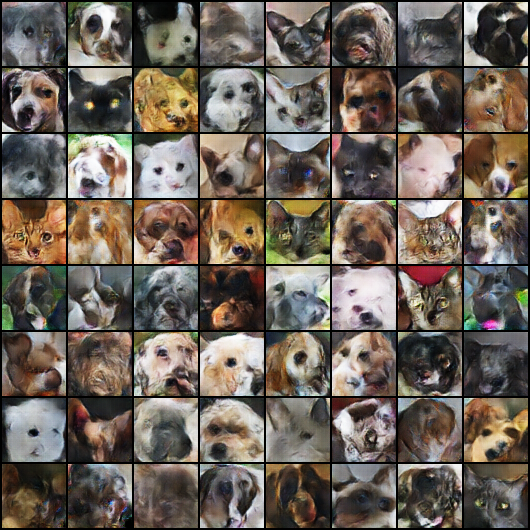

In [30]:
Image('./generated/generated-images-0515.png')